In [6]:
import streamlit as st
import pandas as pd
import numpy as np
from urllib.parse import urlparse
import re
from io import BytesIO
from PIL import Image

# Charger et redimensionner le logo
logo = Image.open("360_capital_vc_logo.jpeg")
logo = logo.resize((64, 64))


# Configuration de la page
st.set_page_config(
    page_title="Nettoyage Données Crunchbase",
    page_icon=logo,
    layout="wide"
)

def get_domain(url):
    """Extrait le domaine d'une URL et le formate"""
    if pd.isna(url):
        return None
    try:
        domain = urlparse(url).netloc
        domain = re.sub(r'^www\d*\.', '', domain).split(':')[0]
        return domain.lower()
    except:
        return None

def clean_crunchbase_data(df):
    """
    Nettoie les données de levées de fonds Crunchbase
    
    Args:
        df: DataFrame avec les colonnes Crunchbase
        
    Returns:
        DataFrame nettoyé avec les colonnes formatées
    """
    # Créer une copie pour ne pas modifier l'original
    df_clean = df.copy()
    
    # 1. Filtrer les types de financement non désirés
    funding_types_to_remove = [
        'Corporate Round',
        'Grant',
        'Post-IPO Debt',
        'Equity Crowdfunding',
        'Debt Financing',
        'Convertible Note',
        'Series C'
    ]
    
    initial_count = len(df_clean)
    df_clean = df_clean[~df_clean['Funding Type'].isin(funding_types_to_remove)]
    filtered_count = initial_count - len(df_clean)
    
    # 2. Convertir les montants USD en devise originale
    mask_usd = df_clean['Money Raised Currency'] == 'USD'
    mask_has_both = pd.notna(df_clean['Money Raised']) & pd.notna(df_clean['Money Raised (in USD)'])
    
    # Calculer le taux de change moyen pour les lignes non-USD
    rates = df_clean[~mask_usd & mask_has_both].apply(
        lambda row: row['Money Raised (in USD)'] / row['Money Raised'] 
        if row['Money Raised'] != 0 else np.nan,
        axis=1
    )
    avg_rate = rates.median() if len(rates) > 0 else 1.0
    
    # Appliquer la conversion inverse pour les montants USD
    df_clean.loc[mask_usd & pd.isna(df_clean['Money Raised']) & pd.notna(df_clean['Money Raised (in USD)']), 'Money Raised'] = \
        df_clean.loc[mask_usd & pd.isna(df_clean['Money Raised']) & pd.notna(df_clean['Money Raised (in USD)']), 'Money Raised (in USD)'] / avg_rate
    
    # 3. Appliquer le formatage des URLs avec get_domain
    df_clean['Website_formatted'] = df_clean['Organization Website'].apply(get_domain)
    
    # 3bis Changer le format des montants 

    df_clean['Money Raised'] = df_clean['Money Raised'].apply(lambda x: f"€M {x:,.0f}" if pd.notna(x) else x)  

    # 4. Créer le nouveau DataFrame avec les colonnes demandées
    df_final = pd.DataFrame({
        'Company Name': df_clean['Organization Name'],
        'Website 2': '',
        'Website': df_clean['Website_formatted'],
        'Description': df_clean['Organization Description'],
        'Secteur': df_clean['Organization Industries'],
        'Date annonce levée': '',
        'Montant': df_clean['Money Raised'],
        'Investisseurs': df_clean['Investor Names']
    })
    
    # Réinitialiser l'index
    df_final = df_final.reset_index(drop=True)
    
    return df_final, filtered_count


# Interface principale
st.title("Nettoyage de Données Crunchbase")
st.markdown("---")

st.markdown("""
### Instructions
        1. Téléchargez votre fichier CSV exporté depuis Crunchbase.
        2. Cliquez sur "Nettoyer les données" pour lancer le processus de nettoyage.
        3. Téléchargez les données nettoyées au format CSV ou Excel.
""")

st.markdown("---")

# Upload du fichier
uploaded_file = st.file_uploader(
    "Chargez votre fichier CSV Crunchbase",
    type=['csv'],
    help="Le fichier doit contenir les colonnes standard de Crunchbase"
)

if uploaded_file is not None:
    try:
        # Lecture du fichier
        df = pd.read_csv(uploaded_file)
        
        st.success(f"✅ Fichier chargé : {len(df)} lignes détectées")
        
        # Afficher un aperçu des données originales
        with st.expander("Aperçu des données originales"):
            st.dataframe(df.head(10), use_container_width=True)
        
        # Bouton de nettoyage
        if st.button("Nettoyer les données", type="primary", use_container_width=True):
            with st.spinner("Nettoyage en cours..."):
                # Nettoyage
                df_clean, filtered_count = clean_crunchbase_data(df)
                
                # Stocker dans session state
                st.session_state['df_clean'] = df_clean
                st.session_state['filtered_count'] = filtered_count
        
        # Afficher les résultats si disponibles
        if 'df_clean' in st.session_state:
            df_clean = st.session_state['df_clean']
            filtered_count = st.session_state['filtered_count']
            
            st.markdown("---")
            st.success("Nettoyage terminé !")
            
            # Statistiques
            col1, col2, col3 = st.columns(3)
            with col1:
                st.metric("Lignes initiales", len(df))
            with col2:
                st.metric("Lignes filtrées", filtered_count)
            with col3:
                st.metric("Lignes finales", len(df_clean))
            
            # Aperçu des données nettoyées
            st.subheader("Données nettoyées")
            st.dataframe(df_clean, use_container_width=True)
            
            # Boutons de téléchargement
            st.markdown("---")
            st.subheader("Télécharger les résultats")
            
            col1, col2 = st.columns(2)
            
            with col1:
                # CSV
                csv = df_clean.to_csv(index=False).encode('utf-8')
                st.download_button(
                    label="Télécharger en CSV",
                    data=csv,
                    file_name="crunchbase_cleaned.csv",
                    mime="text/csv",
                    use_container_width=True
                )
            
    
    except Exception as e:
        st.error(f"❌ Erreur lors du traitement du fichier : {str(e)}")
        st.info("Vérifiez que votre fichier contient bien toutes les colonnes requises.")

else:
    st.info("Charger un fichier CSV")

# Footer
st.markdown("---")
st.markdown(
    """
    <div style='text-align: center; color: gray;'>
    Outil de nettoyage de données Crunchbase 360 Capital 
    </div>
    """,
    unsafe_allow_html=True
)

2025-10-13 17:27:43.410 
  command:

    streamlit run /Users/justinkim/Documents/GitHub/360capital/.venv/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()

In [128]:
def custom(str : str):
    n = len(str)
    l = []
    for i in range(n):
        l.append(str[i])
        print(str[i])
    l.reverse()
    return((''.join(l)).strip())

custom('hello')


h
e
l
l
o


'olleh'

In [ ]:
# check palyndrome

def palyiin(str):
    if str[::-1] == str:
        return True
    else : 
        return False

str = 'alaoaazeazea'
print(str[::-1])


def longest_palindrome(s):
    """
    Plus long substring palindrome.
    Input: s = "babad"
    Output: "bab" ou "aba"
    """
    def expand_around_center(left, right):
        while left >= 0 and right < len(s) and s[left] == s[right]:
            left -= 1
            right += 1
        return right - left - 1
    
    if not s:
        return ""
    
    start, end = 0, 0
    
    for i in range(len(s)):
        # Palindrome impair (centre = 1 char)
        len1 = expand_around_center(i, i)
        # Palindrome pair (centre = 2 chars)
        len2 = expand_around_center(i, i + 1)
        
        max_len = max(len1, len2)
        
        if max_len > end - start:
            start = i - (max_len - 1) // 2
            end = i + max_len // 2
    
    return s[start:end + 1]

# Test
print(longest_palindrome("babad"))  # "bab" ou "aba"

aezaezaaoala


In [21]:
from collections import Counter

l = [1,1,1]

print(Counter(l))

# Pour un dataframe

df.value_counts()

Counter({1: 3})


Series([], Name: count, dtype: int64)

Find indices of two numbers that add up to a specific target in an array.

First we create a dictionary to store numbers and their indices as you iterate through the array. For each number, check if its complement (target minus the number) exists in the dictionary. If it does, return their indices.

In [147]:
def sum(a, target):
    test = a[0]
    index = []
    for i, value in enumerate(a):
        if test + value == target:
            index.append([a.index(test), i])
        else :
            test = value
    return(index)

print(sum([2, 7, 3, 15], 10))

[[1, 2]]


In [23]:
# faire la sum de deux array numpy 
import numpy as np
arr1 = np.array([1, 2])
arr2 = np.array([4, 5])
result = np.add(arr1, arr2)

# extract diag 
import numpy as np
matrix = np.array([[1, 2, 3], [4, 5, 6]])
print(np.diagonal(matrix))

[1 5]


Create a Class to Represent a Person with Basic Attributes.

__init__(self, name, age) initializes the Person object with a name and age.
birthday(self) increases the person's age by 1.
__str__(self) provides a human-readable string representation of the Person object.

In [27]:
class Person:
    def __init__(self, age, name):
        self.age = age
        self.name = name
    
    def birthday(self):
        self.age += 1

    def str(self):
        return(f"Name : {self.name} and Age : {self.age}")
    
perso = Person(12, "Alice")
print(perso.str())
perso.birthday()
print(perso.str())

Name : Alice and Age : 12
Name : Alice and Age : 13


Implement a sliding window to find the maximum sum of a subarray of a given size k.

In [6]:
def subarray(arr, k):
    max = 0
    for i in range(len(arr)):
        if max < sum(arr[i:i+k]):
            max = sum(arr[i:i+k])

    return(max)

print(subarray([2, 1, 5, 1, 3, 2], 3))

9


 Calculate the confidence interval for a given dataset (assume normal distribution).

In [9]:
!pip install scipy

  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (60 kB)
Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl (30.3 MB)


In [10]:
import numpy as np
from scipy.stats import norm

def confidence_interval(data, confidence=0.95):
    mean, std = np.mean(data), np.std(data, ddof=1)
    z = norm.ppf((1 + confidence) / 2)
    margin_of_error = z * (std / np.sqrt(len(data)))
    return mean - margin_of_error, mean + margin_of_error


print(confidence_interval([1, 2, 3, 4, 5]))

(1.614096175650322, 4.385903824349678)


 Implement the Chi-squared test for independence on a contingency table.

Calculate the Chi-squared statistic by comparing observed and expected frequencies in the contingency table.

In [11]:
import numpy as np
from scipy.stats import chi2_contingency

def chi_squared_test(contingency_table):
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p


table = [[10, 20], [20, 40]]
print(chi_squared_test(table))

(0.0, 1.0)


Write a function to handle missing data using multiple imputation.

we use Simple Imputer to replace missing values with the mean or another strategy. Below is the code:

In [13]:
!pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp39-cp39-macosx_12_0_arm64.whl (11.1 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]


In [16]:
from sklearn.impute import SimpleImputer
import numpy as np

def impute_missing_data(data):
    imputer = SimpleImputer(strategy='most_frequent')
    return imputer.fit_transform(data)

data = np.array([[1, 2], [np.nan, 3], [7, 6]])
print(impute_missing_data(data))

[[1. 2.]
 [1. 3.]
 [7. 6.]]


 Group a dataset by a column and calculate the rolling average for another column.

Use pandas.groupby and rolling to calculate rolling averages.

In [19]:
import pandas as pd

In [ ]:
import pandas as pd

data = {
    'Group': ['A', 'A', 'B', 'B', 'C'],
    'Value': [10, 20, 30, 40, 50],
    'Score': [1.5, 2.5, 3.5, 4.5, 5.5]
}
df = pd.DataFrame(data)
print(df)

result = df.groupby('Group').agg({
    'Score': lambda x: x.max() - x.min().min() # la colonne doit exister 
}).reset_index() # à toujours rajouter
print(result)

  Group  Value  Score
0     A     10    1.5
1     A     20    2.5
2     B     30    3.5
3     B     40    4.5
4     C     50    5.5
  Group  Score
0     A    1.0
1     B    1.0
2     C    0.0


In [47]:
df.iloc[:2]


,Group,Value,Averages
0,A,10,10.0
1,A,20,15.0


In [49]:
df['Averages'] = df.groupby('Group')['Value'].rolling(window=2, min_periods=1).mean().reset_index(drop=True)
df

,Group,Value,Averages
0,A,10,10.0
1,A,20,15.0
2,B,30,30.0
3,B,40,35.0


Create a pivot table from raw transactional data.

Use pandas.pivot_table to summarize data into a pivot table.

In [58]:
import pandas as pd

def create_pivot_table(df, index, columns, values, aggfunc):
    return pd.pivot_table(df, index=index, columns=columns, values=values, aggfunc=aggfunc)

data = {'Category': ['A', 'A', 'B'], 'Type': ['X', 'Y', 'X'], 'Value': [10, 20, 30]}
df = pd.DataFrame(data)


pivot_table = create_pivot_table(df, index='Category', columns='Type', values='Value', aggfunc='sum')
print(pivot_table)

Type         X     Y
Category            
A         10.0  20.0
B         30.0   NaN


In [62]:
import pandas as pd

data = { 'First_name': ['Liam', 'Emma', 'Noah', 'Olivia', 'Ava'],
         'Last_name': ['Smith', 'Brown', 'Davis', 'Wilson', 'Taylor'],
         'Age': [42, 52, 36, 21, 23],
         'City': ['New York', 'Paris', 'Berlin', 'Madrid', 'Rome'] }
df = pd.DataFrame(data)
print(df)

new_vals = {"Liam": "MBA", "Emma": "PhD", "Noah": "LLB", "Olivia": "B.Tech", "Ava": "MD"}
df["Qualification"] = df["First_name"].map(new_vals)
print(df)

new_vals = {"Liam": "Lucas", "Noah": "Nathan", "Olivia": "Olive"}
df_replaced = df.replace({"First_name": new_vals})
print(df_replaced)

new_vals = {0: "Lukas", 2: "Nicolas", 3: "Sophia"}
df["First_name"].update(pd.Series(new_vals))
print(df)

  First_name Last_name  Age      City
0       Liam     Smith   42  New York
1       Emma     Brown   52     Paris
2       Noah     Davis   36    Berlin
3     Olivia    Wilson   21    Madrid
4        Ava    Taylor   23      Rome
  First_name Last_name  Age      City Qualification
0       Liam     Smith   42  New York           MBA
1       Emma     Brown   52     Paris           PhD
2       Noah     Davis   36    Berlin           LLB
3     Olivia    Wilson   21    Madrid        B.Tech
4        Ava    Taylor   23      Rome            MD
  First_name Last_name  Age      City Qualification
0      Lucas     Smith   42  New York           MBA
1       Emma     Brown   52     Paris           PhD
2     Nathan     Davis   36    Berlin           LLB
3      Olive    Wilson   21    Madrid        B.Tech
4        Ava    Taylor   23      Rome            MD
  First_name Last_name  Age      City Qualification
0      Lukas     Smith   42  New York           MBA
1       Emma     Brown   52     Paris       

In [77]:
# import pandas module
import pandas as pd

# making dataframe
df = pd.read_csv("https://media.geeksforgeeks.org/wp-content/uploads/nba.csv")

# it was print the first 5-rows
print(df.head())

# reshape the dataframe using stack() method
df_stacked = df.stack()

print(df_stacked[0].keys())
df_stacked[0].items()

            Name            Team  Number Position   Age Height  Weight  \
0  Avery Bradley  Boston Celtics     0.0       PG  25.0    6-2   180.0   
1    Jae Crowder  Boston Celtics    99.0       SF  25.0    6-6   235.0   
2   John Holland  Boston Celtics    30.0       SG  27.0    6-5   205.0   
3    R.J. Hunter  Boston Celtics    28.0       SG  22.0    6-5   185.0   
4  Jonas Jerebko  Boston Celtics     8.0       PF  29.0   6-10   231.0   

             College     Salary  
0              Texas  7730337.0  
1          Marquette  6796117.0  
2  Boston University        NaN  
3      Georgia State  1148640.0  
4                NaN  5000000.0  
Index(['Name', 'Team', 'Number', 'Position', 'Age', 'Height', 'Weight',
       'College', 'Salary'],
      dtype='object')


In [83]:
for key, element in enumerate(df):
    print(key, element)
# unstack() method
df_unstacked = df_stacked.unstack()
print(df_unstacked.head(10))

0 Name
1 Team
2 Number
3 Position
4 Age
5 Height
6 Weight
7 College
8 Salary
            Name            Team Number Position   Age Height Weight  \
0  Avery Bradley  Boston Celtics    0.0       PG  25.0    6-2  180.0   
1    Jae Crowder  Boston Celtics   99.0       SF  25.0    6-6  235.0   
2   John Holland  Boston Celtics   30.0       SG  27.0    6-5  205.0   
3    R.J. Hunter  Boston Celtics   28.0       SG  22.0    6-5  185.0   
4  Jonas Jerebko  Boston Celtics    8.0       PF  29.0   6-10  231.0   
5   Amir Johnson  Boston Celtics   90.0       PF  29.0    6-9  240.0   
6  Jordan Mickey  Boston Celtics   55.0       PF  21.0    6-8  235.0   
7   Kelly Olynyk  Boston Celtics   41.0        C  25.0    7-0  238.0   
8   Terry Rozier  Boston Celtics   12.0       PG  22.0    6-2  190.0   
9   Marcus Smart  Boston Celtics   36.0       PG  22.0    6-4  220.0   

             College      Salary  
0              Texas   7730337.0  
1          Marquette   6796117.0  
2  Boston University     

In [86]:

df

,Name,Team,Number,Position,Age,Height,Weight,College,Salary
0,Avery Bradley,Boston Celtics,0.0,PG,25.0,6-2,180.0,Texas,7730337.0
1,Jae Crowder,Boston Celtics,99.0,SF,25.0,6-6,235.0,Marquette,6796117.0
2,John Holland,Boston Celtics,30.0,SG,27.0,6-5,205.0,Boston University,NaN
3,R.J. Hunter,Boston Celtics,28.0,SG,22.0,6-5,185.0,Georgia State,1148640.0
4,Jonas Jerebko,Boston Celtics,8.0,PF,29.0,6-10,231.0,NaN,5000000.0
...,...,...,...,...,...,...,...,...,...
453,Shelvin Mack,Utah Jazz,8.0,PG,26.0,6-3,203.0,Butler,2433333.0
454,Raul Neto,Utah Jazz,25.0,PG,24.0,6-1,179.0,NaN,900000.0
455,Tibor Pleiss,Utah Jazz,21.0,C,26.0,7-3,256.0,NaN,2900000.0
456,Jeff Withey,Utah Jazz,24.0,C,26.0,7-0,231.0,Kansas,947276.0


In [103]:
df_copy = df.copy()

df_copy = df_copy.query('Age < 25')
df_copy

indices_to_drop = df_copy[df_copy['Weight'] < 185].index # récupérer les index
df.drop(indices_to_drop, inplace=True)
print(df.head(10))

            Name            Team  Number Position   Age Height  Weight  \
0  Avery Bradley  Boston Celtics     0.0       PG  25.0    6-2   180.0   
1    Jae Crowder  Boston Celtics    99.0       SF  25.0    6-6   235.0   
2   John Holland  Boston Celtics    30.0       SG  27.0    6-5   205.0   
3    R.J. Hunter  Boston Celtics    28.0       SG  22.0    6-5   185.0   
4  Jonas Jerebko  Boston Celtics     8.0       PF  29.0   6-10   231.0   
5   Amir Johnson  Boston Celtics    90.0       PF  29.0    6-9   240.0   
6  Jordan Mickey  Boston Celtics    55.0       PF  21.0    6-8   235.0   
7   Kelly Olynyk  Boston Celtics    41.0        C  25.0    7-0   238.0   
8   Terry Rozier  Boston Celtics    12.0       PG  22.0    6-2   190.0   
9   Marcus Smart  Boston Celtics    36.0       PG  22.0    6-4   220.0   

             College      Salary  
0              Texas   7730337.0  
1          Marquette   6796117.0  
2  Boston University         NaN  
3      Georgia State   1148640.0  
4         

In [97]:
df.iloc[1,:]

Name           Jae Crowder
Team        Boston Celtics
Number                99.0
Position                SF
Age                   25.0
Height                 6-6
Weight               235.0
College          Marquette
Salary           6796117.0
Name: 1, dtype: object

In [113]:
df.loc[0:1] # ici les index sont des nombres mais la différence c'est qu'on peut utiliser les noms

,Name,Team,Number,Position,Age,Height,Weight,College,Salary
0,Avery Bradley,Boston Celtics,0.0,PG,25.0,6-2,180.0,Texas,7730337.0
1,Jae Crowder,Boston Celtics,99.0,SF,25.0,6-6,235.0,Marquette,6796117.0


In [116]:
df.query('Position != "PG"')

,Name,Team,Number,Position,Age,Height,Weight,College,Salary
1,Jae Crowder,Boston Celtics,99.0,SF,25.0,6-6,235.0,Marquette,6796117.0
2,John Holland,Boston Celtics,30.0,SG,27.0,6-5,205.0,Boston University,NaN
3,R.J. Hunter,Boston Celtics,28.0,SG,22.0,6-5,185.0,Georgia State,1148640.0
4,Jonas Jerebko,Boston Celtics,8.0,PF,29.0,6-10,231.0,NaN,5000000.0
5,Amir Johnson,Boston Celtics,90.0,PF,29.0,6-9,240.0,NaN,12000000.0
...,...,...,...,...,...,...,...,...,...
451,Chris Johnson,Utah Jazz,23.0,SF,26.0,6-6,206.0,Dayton,981348.0
452,Trey Lyles,Utah Jazz,41.0,PF,20.0,6-10,234.0,Kentucky,2239800.0
455,Tibor Pleiss,Utah Jazz,21.0,C,26.0,7-3,256.0,NaN,2900000.0
456,Jeff Withey,Utah Jazz,24.0,C,26.0,7-0,231.0,Kansas,947276.0


In [114]:
df.loc[df['Position'] != 'PG']

,Name,Team,Number,Position,Age,Height,Weight,College,Salary
1,Jae Crowder,Boston Celtics,99.0,SF,25.0,6-6,235.0,Marquette,6796117.0
2,John Holland,Boston Celtics,30.0,SG,27.0,6-5,205.0,Boston University,NaN
3,R.J. Hunter,Boston Celtics,28.0,SG,22.0,6-5,185.0,Georgia State,1148640.0
4,Jonas Jerebko,Boston Celtics,8.0,PF,29.0,6-10,231.0,NaN,5000000.0
5,Amir Johnson,Boston Celtics,90.0,PF,29.0,6-9,240.0,NaN,12000000.0
...,...,...,...,...,...,...,...,...,...
451,Chris Johnson,Utah Jazz,23.0,SF,26.0,6-6,206.0,Dayton,981348.0
452,Trey Lyles,Utah Jazz,41.0,PF,20.0,6-10,234.0,Kentucky,2239800.0
455,Tibor Pleiss,Utah Jazz,21.0,C,26.0,7-3,256.0,NaN,2900000.0
456,Jeff Withey,Utah Jazz,24.0,C,26.0,7-0,231.0,Kansas,947276.0


In [88]:
df.shape[0], df.shape[1]

(458, 9)

In [100]:
row = []
for i in range(df.shape[0]):
    row.append(list(df.iloc[i,:]))

print(row[0])

['Avery Bradley', 'Boston Celtics', 0.0, 'PG', 25.0, '6-2', 180.0, 'Texas', 7730337.0]


insérer des élements à n'importe quel endroit 

In [118]:
new_row2 = ['Jae Cr','Boston Celtics',	99.0,	'SF'	,25.0,	6-6,	235.0	,'Marquette',	6796117.0]

# Copy original DataFrame
df2 = df.copy()

# Insert row at position 1
df2.loc[1.5] = new_row2
df2 = df2.sort_index().reset_index(drop=True)
df2

,Name,Team,Number,Position,Age,Height,Weight,College,Salary
0,Avery Bradley,Boston Celtics,0.0,PG,25.0,6-2,180.0,Texas,7730337.0
1,Jae Crowder,Boston Celtics,99.0,SF,25.0,6-6,235.0,Marquette,6796117.0
2,Jae Cr,Boston Celtics,99.0,SF,25.0,0,235.0,Marquette,6796117.0
3,John Holland,Boston Celtics,30.0,SG,27.0,6-5,205.0,Boston University,NaN
4,R.J. Hunter,Boston Celtics,28.0,SG,22.0,6-5,185.0,Georgia State,1148640.0
...,...,...,...,...,...,...,...,...,...
446,Trey Lyles,Utah Jazz,41.0,PF,20.0,6-10,234.0,Kentucky,2239800.0
447,Shelvin Mack,Utah Jazz,8.0,PG,26.0,6-3,203.0,Butler,2433333.0
448,Tibor Pleiss,Utah Jazz,21.0,C,26.0,7-3,256.0,NaN,2900000.0
449,Jeff Withey,Utah Jazz,24.0,C,26.0,7-0,231.0,Kansas,947276.0


In [123]:
result = df.sort_values(by=['Age', 'Weight'], ascending=True)  
result

,Name,Team,Number,Position,Age,Height,Weight,College,Salary
226,Rashad Vaughn,Milwaukee Bucks,20.0,SG,19.0,6-6,202.0,UNLV,1733040.0
122,Devin Booker,Phoenix Suns,1.0,SG,19.0,6-6,206.0,Kentucky,2127840.0
445,Dante Exum,Utah Jazz,11.0,PG,20.0,6-6,190.0,NaN,3777720.0
116,D'Angelo Russell,Los Angeles Lakers,1.0,PG,20.0,6-5,195.0,Ohio State,5103120.0
401,Tyus Jones,Minnesota Timberwolves,1.0,PG,20.0,6-2,195.0,Duke,1282080.0
...,...,...,...,...,...,...,...,...,...
261,Vince Carter,Memphis Grizzlies,15.0,SG,39.0,6-6,220.0,North Carolina,4088019.0
304,Andre Miller,San Antonio Spurs,24.0,PG,40.0,6-3,200.0,Utah,250750.0
400,Kevin Garnett,Minnesota Timberwolves,21.0,PF,40.0,6-11,240.0,NaN,8500000.0
298,Tim Duncan,San Antonio Spurs,21.0,C,40.0,6-11,250.0,Wake Forest,5250000.0


In [128]:
df['Rank'] = df['Salary'].rank(method='average', ascending=False) # pour rank par rapport à une features 
df.sort_values(by='Rank').head(5)

,Name,Team,Number,Position,Age,Height,Weight,College,Salary,Rank
109,Kobe Bryant,Los Angeles Lakers,24.0,SF,37.0,6-6,212.0,NaN,25000000.0,1.0
169,LeBron James,Cleveland Cavaliers,23.0,SF,31.0,6-8,250.0,NaN,22970500.0,2.0
33,Carmelo Anthony,New York Knicks,7.0,SF,32.0,6-8,240.0,Syracuse,22875000.0,3.0
251,Dwight Howard,Houston Rockets,12.0,C,30.0,6-11,265.0,NaN,22359364.0,4.0
339,Chris Bosh,Miami Heat,1.0,PF,32.0,6-11,235.0,Georgia Tech,22192730.0,5.0


# PySpark

In [129]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.2/434.2 MB 53.3 MB/s  0:00:07:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyspark: filename=pyspark-4.0.1-py2.py3-none-any.whl size=434813860 sha256=b5c5785be07adfcdddeae573b9a2b18bb5347becc5ed9da341396bacd0d7e69f
  Stored in directory: /Users/justinkim/Library/Caches/pip/wheels/10/e6/6b/c50eb601fa827dd56a5272db5d5db360e559e527a80a665b1d
Successfully built pyspark
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pyspark]m1/2 [pyspark]


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, when, lit
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

# 1. Initialisation de la session Spark
spark = SparkSession.builder \
    .appName("ExempleDataFrameSpark") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# 2. Définition d'un schéma pour le DataFrame (optionnel, pour un contrôle précis)
schema = StructType([
    StructField("id", IntegerType(), False),
    StructField("nom", StringType(), True),
    StructField("age", IntegerType(), True),
    StructField("salaire", DoubleType(), True),
    StructField("ville", StringType(), True)
])

# 3. Création d'un DataFrame à partir de données brutes (si pas de fichier CSV)
data = [
    (1, "Alice", 25, 50000.0, "Paris"),
    (2, "Bob", 30, 60000.0, "Lyon"),
    (3, "Charlie", 35, 75000.0, "Marseille"),
    (4, "David", 28, 55000.0, "Paris"),
    (5, "Emma", 40, 80000.0, None)
]

df = spark.createDataFrame(data, schema)

# Alternativement, charger un DataFrame depuis un fichier CSV
# df = spark.read.csv("path/to/data.csv", header=True, schema=schema)

# 4. Afficher le schéma du DataFrame
print("Schéma du DataFrame :")
df.printSchema()

# 5. Afficher les premières lignes
print("Aperçu des données :")
df.show(5, truncate=False)

# 6. Exemple de transformations
# a. Filtrer les lignes où l'âge est supérieur à 30
df_filtre = df.filter(col("age") > 30)
print("Personnes de plus de 30 ans :")
df_filtre.show()

# b. Ajouter une nouvelle colonne basée sur une condition
df = df.withColumn("categorie_age", 
                   when(col("age") < 30, "Jeune")
                   .when(col("age") <= 35, "Adulte")
                   .otherwise("Senior"))
print("DataFrame avec nouvelle colonne :")
df.show()

# c. Grouper et agréger : calculer le salaire moyen par ville
df_agg = df.groupBy("ville").agg(
    avg("salaire").alias("salaire_moyen"),
    count("id").alias("nombre_personnes")
)
print("Salaire moyen et nombre de personnes par ville :")
df_agg.show()

# 7. Gestion des valeurs manquantes
# Remplacer les valeurs nulles dans la colonne 'ville' par 'Inconnu'
df = df.na.fill({"ville": "Inconnu"})
print("DataFrame après remplacement des valeurs nulles :")
df.show()

# 8. Jointure avec un autre DataFrame
# Création d'un DataFrame pour les départements
data_dep = [(1, "Paris", "Île-de-France"), (2, "Lyon", "Auvergne-Rhône-Alpes"), (3, "Inconnu", "Inconnu")]
schema_dep = StructType([
    StructField("id_dep", IntegerType(), False),
    StructField("ville", StringType(), True),
    StructField("region", StringType(), True)
])
df_dep = spark.createDataFrame(data_dep, schema_dep)

# Jointure sur la colonne 'ville'
df_joined = df.join(df_dep, "ville", "left")
print("DataFrame après jointure :")
df_joined.show()

# 9. Sauvegarde des résultats
# Sauvegarder le DataFrame transformé en format Parquet
df.write.mode("overwrite").parquet("output/transformed_data")

# Sauvegarder les résultats agrégés en CSV
df_agg.write.mode("overwrite").csv("output/aggregated_data", header=True)

# 10. Utilisation de SQL avec Spark
# Créer une vue temporaire pour exécuter des requêtes SQL
df.createOrReplaceTempView("personnes")
result_sql = spark.sql("""
    SELECT ville, AVG(salaire) as salaire_moyen, COUNT(*) as nombre
    FROM personnes
    GROUP BY ville
    HAVING COUNT(*) > 1
""")
print("Résultat de la requête SQL :")
result_sql.show()

# 11. Arrêter la session Spark
spark.stop()

# CNN 

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [ ]:
model = models.Sequential()

In [338]:
import pandas as pd
import numpy as np

# data of 2018 drivers world championship
dict1 = {'Driver': ['Hamilton', 'Vettel', 'Raikkonen',
                    'Verstappen', 'Bottas', 'Ricciardo',
                    'Hulkenberg', 'Perez', 'Magnussen',
                    'Sainz', 'Alonso', 'Ocon', 'Leclerc',
                    'Grosjean', 'Gasly', 'Vandoorne',
                    'Ericsson', 'Stroll', 'Hartley', 'Sirotkin'],

         'Points': [408, 320, 251, 249, 247, 170, 69, 62, 56,
                    53, 50, 49, 39, 37, 29, 12, 9, 6, 4, 1],

         'Age': [33, 31, 39, 21, 29, 29, 31, 28, 26, 24, 37,
                 22, 21, 32, 22, 26, 28, 20, 29, 23]}

# creating dataframe using DataFrame constructor
df = pd.DataFrame(dict1)
print(df.head(10))

       Driver  Points  Age
0    Hamilton     408   33
1      Vettel     320   31
2   Raikkonen     251   39
3  Verstappen     249   21
4      Bottas     247   29
5   Ricciardo     170   29
6  Hulkenberg      69   31
7       Perez      62   28
8   Magnussen      56   26
9       Sainz      53   24


In [258]:
df['Points'] 
df.Points

0     408
1     320
2     251
3     249
4     247
5     170
6      69
7      62
8      56
9      53
10     50
11     49
12     39
13     37
14     29
15     12
16      9
17      6
18      4
19      1
Name: Points, dtype: int64

In [347]:
df.nsmallest(5, ['Age'])

,Driver,Points,Age,Nul,Statut,stat,Score Normalisé par age,Autre point
17,Stroll,6,20,0,Yes,A le droit,0.300000,19.4
3,Verstappen,249,21,0,Yes,A le droit,8.517241,-3.9
12,Leclerc,39,21,0,Yes,A le droit,1.351351,17.1
11,Ocon,49,22,0,Yes,A le droit,1.857143,17.1
14,Gasly,29,22,0,Yes,A le droit,1.156250,19.1


# Recap

In [ ]:
# TOP SALES
Récupérer le produit le plus vendu df.loc[df.groupby('region')['sales'].idxmax()] 
    # 4. Leader par marché-année
    idx_max = agg_df.groupby(['year', 'market'])['revenue'].idxmax()
    agg_df['is_leader'] = False # CREER UNE NOUVELLE COLONNE OU MERGE 
    agg_df.loc[idx_max, 'is_leader'] = True

# CATEGORY LA PLUS FREQUENTE
Catégorie les plus fréquentes ('category', pd.Series.mode) ou  lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0])


# DELTA TIME ENTRE UNE LIVRAISON 
days_active=('order_date', lambda x: (x.max() - x.min()).days)  (dt c'est avec une series)
                                                                 
+# CALCUL DUN POURCENTAGE RAJOUTE 
market_data.groupby(['market','year'])['revenue'].sum() 
NON ==>
market_data['total_group'] = market_data.groupby(['market','year'])['revenue'].transform('sum')

# Calculer le % de contribution de chaque ligne
market_data['pct_of_group'] = market_data['revenue'] / market_data['total_group'] * 100


# CROISSANCE YTY 
agg_df['yoy_growth'] = agg_df.groupby(['market', 'company'])['market_share'].pct_change() * 100


# Calcul sur une colonne avec apply 
    herfindahl = agg_df.groupby(['year', 'market']).apply(
        lambda x: (x['market_share'] ** 2).sum() / 100
    ).reset_index(name='herfindahl_index')
    
    
# RANK
sales['rang_region'] = sales.groupby('region')['ventes'].rank(ascending=False, methode = 'dense')

In [ ]:
# EXERCICE 1

import pandas as pd

data = {
    'date': ['2024-01-01', '2024-01-01', '2024-01-02', '2024-01-02', '2024-01-03'],
    'region': ['North', 'South', 'North', 'South', 'North'],
    'product': ['A', 'B', 'A', 'B', 'C'],
    'sales': [100, 150, 120, 180, 90],
    'units': [10, 15, 12, 18, 9]
}
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(data['date'])

df.groupby('region').agg({
    'sales' : ['mean', 'sum'],
    'region' : 'count'
})


# Récupérer le produit le plus vendu df.loc[df.groupby('region')['sales'].idxmax()]
print(df.groupby(['product', 'region'])['sales'].idxmax())
index_top_produit = df.groupby('region')['sales'].idxmax()


top_prod = df.loc[index_top_produit]
top_prod


result = df.groupby('region').agg(
    total_sales=('sales', 'sum'),
    avg_sales=('sales', 'mean'),
    num_transactions=('sales', 'count')
).reset_index()
top_products = df.loc[df.groupby('region')['sales'].idxmax()]
print(top_products)


# Merger avec les top_products
result = result.merge(
    top_products[['region', 'product']].rename(columns={'product': 'top_product'}),
    on='region'
)

# EXERCICE 2

customers = pd.DataFrame({
    'customer_id': [1, 1, 1, 2, 2, 3, 3, 3, 3],
    'order_date': pd.date_range('2024-01-01', periods=9, freq='D'),
    'order_value': [100, 150, 200, 80, 120, 300, 250, 400, 350],
    'category': ['Electronics', 'Clothing', 'Electronics', 
                 'Food', 'Food', 'Electronics', 'Electronics', 'Furniture', 'Electronics']
})

customers['order_date'] = pd.to_datetime(customers['order_date'])
customers['days'] = customers['order_date'].dt.day

    

customers.groupby('customer_id').agg(
    nb_tot_commande = ('order_value', 'count'),
    valeur_tot_commande = ('order_value', 'sum'),
    valeur_moy_commande = ('order_value', 'mean'),
    cat_frequent = ('category', pd.Series.mode),
    delta_t = ('days',lambda x : max(x)-min(x) )
)

# EXERCICE 3
import numpy as np

sales_data = pd.DataFrame({
    'date': pd.date_range('2023-01-01', periods=100, freq='W'),
    'region': np.random.choice(['North', 'South', 'East', 'West'], 100),
    'product': np.random.choice(['Product_A', 'Product_B', 'Product_C'], 100),
    'sales': np.random.randint(1000, 10000, 100),
    'profit': np.random.randint(100, 2000, 100)
})
sales_data['quarter'] = sales_data['date'].dt.quarter
sales_data['year'] = sales_data['date'].dt.year

table_pivot = pd.pivot_table(sales_data, index=['region','product'], columns=['year','quarter'], values='sales', aggfunc='sum',fill_value= 0, margins = True)
sales_data['quarter_year'] = (
sales_data['year'].astype(str) + '-Q' + 
sales_data['quarter'].astype(str)
)

# EXERCICE 4

market_data = pd.DataFrame({
    'year': [2022]*12 + [2023]*12 + [2024]*12,
    'month': list(range(1, 13)) * 3,
    'company': np.random.choice(['CompanyA', 'CompanyB', 'CompanyC', 'CompanyD'], 36),
    'revenue': np.random.randint(10000, 100000, 36),
    'market': np.random.choice(['USA', 'Europe', 'Asia'], 36)
})

market_data['market_total'] = market_data.groupby(['year', 'market'])['revenue'].transform('sum')

# 2. Part de marché
market_data['market_share'] = market_data['revenue'] / market_data['market_total'] * 100
    
agg_df = market_data.groupby(['year', 'market', 'company']).agg({
    'revenue': 'sum',
    'market_share': 'mean'
}).reset_index()

# Trier et calculer YoY
agg_df = agg_df.sort_values(['market', 'company', 'year'])
agg_df['yoy_growth'] = agg_df.groupby(['market', 'company'])['market_share'].pct_change() * 100

agg_df



product  region
A        North     2
B        South     3
C        North     4
Name: sales, dtype: int64
        date region product  sales  units
2 2024-01-02  North       A    120     12
3 2024-01-02  South       B    180     18


**Question:**
Pour chaque produit, calculer:
1. Moving average 7 jours
2. Moving average 30 jours
3. Trend (différence entre MA7 et MA30)
4. Volatilité (rolling std 7 jours)
5. Signal: "BUY" si MA7 > MA30 et trend positif, "SELL" sinon
6. Cumulative sales YTD (Year-to-date)

In [85]:
# EXERCICE 5

time_series = pd.DataFrame({
    'date': pd.date_range('2023-01-01', periods=365, freq='D'),
    'product': np.random.choice(['Product_A', 'Product_B', 'Product_C'], 365),
    'sales': np.random.randint(100, 1000, 365) + 
             np.sin(np.arange(365) * 2 * np.pi / 365) * 200  # Seasonalité
})

time_series

,date,product,sales
0,2023-01-01,Product_A,132.000000
1,2023-01-02,Product_C,715.442671
2,2023-01-03,Product_B,548.884322
3,2023-01-04,Product_C,564.323933
4,2023-01-05,Product_C,828.760485
...,...,...,...
360,2023-12-27,Product_B,757.807040
361,2023-12-28,Product_A,572.239515
362,2023-12-29,Product_C,648.676067
363,2023-12-30,Product_B,972.115678


In [ ]:
# Pivot table Let's start by creating a simple pivot table. 
# Suppose you have data about different products, and you want to see the average price of each product category:

pivot_table = df.pivot_table(index='Product', values='Price', aggfunc='mean')
pivot = titanic.pivot_table(index='class', columns='sex', values=['survived', 'fare'], aggfunc='mean')

# TODO: create a pivot table that summarizes the sum of toy sales by toy type and store.
pivot_table = pd.pivot_table(df, index = 'Toy', columns='Store', values = 'Sales' , aggfunc='sum') # la aggfnc sur les values

# TODO: Create a pivot table that shows the average (mean) price and quantity of products grouped by category and product type

pivot_table = pd.pivot_table(df, values=['Price', 'Quantity'], index=['Category', 'Product'], aggfunc={'Price': 'mean', 'Quantity': 'sum'})

In [ ]:
df["IsYouthful"] = df["Age"].apply(lambda age: "Yes" if age < 30 else "No")

df2 = pd.DataFrame({"Name": ["Megan"], "Age": [34], "City": ["San Francisco"], "IsYouthful": ["No"]})

df_concatenated = pd.concat([df, df2], ignore_index=True)

print(df_concatenated)

# Sort survivors by age
sorted_df = survivors.sort_values('age')
sorted_df = survivors.sort_values(['pclass', 'age'], ascending=[False, True])

#create a rank 
library['rank'] = library['rating'].rank(axis = 0, method = 'dense', ascending = False) # ascendign False la plus grosse note aura rank 1

# add new row avec concat
new_row = pd.DataFrame({'Grocery Item': ['Pears'], 'Price per kg': [4.00]})

grocery_df = pd.concat([grocery_df, new_row]).reset_index(drop=True)

# remove row 
index_to_delete = grocery_df[grocery_df['Grocery Item'] == 'Grapes'].index
indices_to_delete = grocery_df[grocery_df['Grocery Item'].isin(['Apples', 'Oranges'])].index
grocery_df = grocery_df.drop(index_to_delete)

print(grocery_df)

In [ ]:
df.shape 

# Select une colonne 
df.Points
df['Points']

# Select une row
df.iloc[1]
# Select plusieurs rows
df.iloc[0:3]
df.loc[0, 'column_name'] # Data in row 0 and column ‘column_name’ pour les labesls


# Select randomly rows
sampled_df = df.sample(frac=0.5).reset_index().drop('index', axis=1)

# Select row that contains a certain string 

#print(df[df["Driver"].str.contains("ami")]) # on peut mettre un OR contient result = df[df["Team"].str.contains("Boston") | df["College"].str.contains("MIT")] 

# Create a list, a dict from rows

#print(df.value_counts())
#print(df.values.tolist())
#print(df.to_numpy().tolist())
#print(df.to_dict(orient='records')) # list of dict
#print([list(row) for row in df.itertuples(index=False)]) # pour les grandes base de données

# Drop une colonne 
#df = df.drop(df.iloc[:, 1:3], axis=1)
#df = df.drop('Points', axis=1)
#df.pop('col')
# Drop columns with more than 50% missing values
#threshold = len(df) * 0.5
#df = df.dropna(thresh=threshold, axis=1)

# Créer une colonne 
l_a_rajouter = [0 for i in range(len(df))]
df['Nul'] = l_a_rajouter

# Pour itérer sur une colonne et en créer une nouvelle avec un statut, High salary par exemple
statut = []
for age in df['Age']:
    if age>18:
        statut.append('Yes')
df['Statut'] = statut

bins = [0,18,40]
lab = ['Non', 'A le droit']
df['stat'] = pd.cut(df['Age'], bins = bins, labels = lab) # possible de le faire avce binning

# pour itérer sur le nom des colonnes 

#for col in df.columns:
    #print(col)


# Récupérer le nom des colonnes

#print(df.columns.to_list())
#print(sorted(df.columns.values))
#print(df.keys())

# récupérer les values unique d'une colonne 
print(sorted(df['Age'].unique()))
print(df['Age'].nunique())
print(df['Age'].value_counts())
print(df['Age'].value_counts().max())
df.groupby('Age').size()
pd.crosstab(index=df['Age'], columns='count')


# Modifier index avec une colonne
d = df.copy()
d.index = d.pop("Driver")
#df.set_index('Age')
#print(d)

# Get l'index du max dans un dataframe

i_min , min = 0, df['Age'][0]
for i in range(len(df)):
    if df['Age'][i]<min:
        min = df['Age'][i]
        i_min = i
print(i_min, min)

df.min()
df[df.Points == df.Points.min()]

df[['Age']].idxmax() # PLUS SIMPLE POUR LINDEX DU MAX
df.nlargest(5, ['Age']) # Pour avoir accès au n value les plus grandes
df.nsmallest(5, ['Age'])

# Rename les colonnes 

df_co = df.copy()
df_co.rename(columns={'Driver' : 'A', 'Points' : 'B' , 'Age': 'C',  'Nul': 'D',  'Statut': 'E',  'stat': 'F'}, inplace=True)

l = [i for i in range(len(df_co.columns.to_list()))]
df_co.columns = l

#df_co.add_prefix('new_') 

# Duplicates 
df['Age'].drop_duplicates()
unique_set = set(df['Age'])
print(unique_set)

# Créer une nouvelle colonne fonction des autres
max = df['Points'].max() 
df["Score Normalisé par age"] = df.apply(lambda x : x['Points']/x['Age'], axis = 1  )
sorted(df["Score Normalisé par age"].to_numpy(), reverse=True)
df["Score Normalisé par age"] = sorted(df["Score Normalisé par age"].to_numpy(), reverse=True)

df['Autre point'] = df['Age'] - (0.1 * df['Points'])


# Data processing 
df.dropna()
df.fillna(0)
df.interpolate()  # Fills missing values using interpolation
df.isnull() # ou notnull()

df['column_name'] = df['column_name'].astype('int') # conversion datatype
df['category_column'] = df['category_column'].astype('category')

df.sort_values(by='column_name', ascending=False)

# Memory handling 
df.memory_usage(deep=True) # indentify wich columns use le plus de mémoire
for chunk in pd.read_csv('large_file.csv', chunksize=10000):
    process(chunk)

df['column_name'] = pd.to_numeric(df['column_name'], downcast='float')

# Save un df 
df.to_excel('output.xlsx', sheet_name='Sheet1', index=False)
df.to_csv('output.csv', index=False)

# ouvrir un json ou un html
df.to_json('output.json')
df.to_html('output.html')

[20, 21, 22, 23, 24, 26, 28, 29, 31, 32, 33, 37, 39]
13
Age
29    3
31    2
21    2
28    2
26    2
22    2
33    1
39    1
24    1
37    1
32    1
20    1
23    1
Name: count, dtype: int64
3
17 20


AttributeError: 'DataFrame' object has no attribute 'Points'

In [9]:
import pandas as pd

In [10]:
# Create the dataframe
df = pd.DataFrame({'Date':['10/2/2011', '11/2/2011', '12/2/2011', '13/2/2011'],
                   'Product':['Umbrella', 'Mattress', 'Badminton', 'Shuttle'],
                   'Last Price':[1200, 1500, 1600, 352],
                   'Updated Price':[1250, 1450, 1550, 400],
                   'Discount':[10, 10, 10, 10]})
df

Final_cost = []
for element in df['Updated Price']:
    if element != 'NaN' :
        Final_cost.append(element*(0.9))
df['Final Price'] = Final_cost
df

# Check si la colonne est présente 
if {'Updated Price', 'Discount'}.issubset(df.columns):
    df['Final cost'] = df['Updated Price'] - (df['Updated Price']*0.1)

elif {'Last Price', 'Discount'}.issubset(df.columns):
    df['Final cost'] = df['Last Price'] - (df['Last Price']*0.1)

# Create the dataframe
df = pd.DataFrame({'Date':['10/2/2011', '11/2/2011', '12/2/2011', '13/2/2011'],
                   'Product':['Umbrella', 'Mattress', 'Badminton', 'Shuttle'],
                   'Last_Price':[1200, 1500, 1600, 352],
                   'Updated_Price':[1250, 1450, 1550, 400],
                   'Discount':[10, 10, 10, 10]})

# Create the indexes
df.index =[f'Item {i}' for i in range(len(df))]

# recherche dans les index qui satisfait une condition 
df
df.query('Updated_Price > 1250').index.to_list()

['Item 1', 'Item 2']

In [22]:
# Exemple de pivot table : moyenne du prix mis à jour par produit

pivot = df.pivot_table(index='Product', values='Updated_Price', aggfunc='mean')
print(pivot)

# crosstab pour relationship entre les variables
crosstab = pd.crosstab(df['Product'], df['Discount'], margins=True)
print(crosstab)

           Updated_Price
Product                 
Badminton         1550.0
Mattress          1450.0
Shuttle            400.0
Umbrella          1250.0
Discount   10  All
Product           
Badminton   1    1
Mattress    1    1
Shuttle     1    1
Umbrella    1    1
All         4    4


In [ ]:
# Pour remplacer des valeurs dans une colonne 
# Define an incomplete dictionary
df = pd.DataFrame({'Date':['10/2/2011', '11/2/2011', '12/2/2011', '13/2/2011'],
                    'Event':['Music', 'Poetry', 'Theatre', 'Comedy'],
                    'Cost':[10000, 5000, 15000, 2000]})
d = {'Music': 'M', 'Poetry': 'P'}

# Apply map() and handle missing values
df['Event'] = df['Event'].map(d).fillna('Unknown')

# split des tring colonnes
df = pd.DataFrame({
    'Name': ['John Larter', 'Robert Junior', 'Jonny Depp'],
    'Age': [32, 34, 36]
})



            Name  Age
0    John Larter   32
1  Robert Junior   34
2     Jonny Depp   36


In [ ]:
# ENCODING DATASET 

# TODO: Convert the 'embarked' column to categorical type

titanic['embarked'] = titanic['embarked'].astype('category')

# TODO: Create a new column 'embarked_code' with encoded categories LABEL ENCODING
titanic['embarked_code'] = titanic['embarked'].cat.codes

print(titanic[['embarked', 'embarked_code']].head())

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
titanic['embarked_code'] = le.fit_transform(titanic['embarked'].fillna('missing'))

# get dummies pour rajouter colonne one hot encoding
dummies = pd.get_dummies(titanic['embarked'],prefix = 'embarked')
print(pd.concat([titanic, dummies], axis=1))

# CodeSignals

🔑 Points clés Two Pointers
✅ Utiliser quand:

Array/string est trié ou peut être trié
Besoin de trouver des paires
Optimiser une solution O(n²)

❌ Ne pas utiliser si:

Array n'est pas trié ET ne peut pas être trié
Besoin de garder l'ordre original
Recherche plus complexe qu'une paire


🔑 Points clés Sliding Window
✅ Utiliser quand:

Sous-array/substring contigus
Fenêtre de taille k fixe
Condition sur le contenu de la fenêtre

❌ Ne pas utiliser si:

Éléments non contigus
Besoin d'ordre non-linéaire
Sous-ensembles non-contigus

Astuce: Si vous voyez "sous-array", "substring", "fenêtre de taille k" → pensez Sliding Window!

🔑 Points clés Hash Map
✅ Utiliser quand:

Compter fréquences
Recherche rapide (O(1))
Détecter duplicatas
Grouper par propriété

❌ Éviter si:

Besoin d'ordre trié
Besoin du k-ième élément (utiliser heap)
Contraintes d'espace strictes


=> Binary Search 
🔑 Points clés Binary Search
✅ Utiliser quand:

Array trié
Recherche dans range/espace monotone
"Trouver minimum/maximum qui satisfait X"

❌ Éviter si:

Array non trié et ne peut être trié
Recherche non-monotone
Besoin de tous les éléments

Astuce: Si vous voyez "trié" ou "minimum/maximum satisfaisant condition" → pensez Binary Search!
### Utilise `left <= right` si :
- ✅ Tu cherches un **élément exact**
- ✅ Tu veux retourner `-1` si pas trouvé
- ✅ Tu es familier avec le binary search "classique"

### Utilise `left < right` si :
- ✅ Tu cherches une **position** (insertion, lower_bound)
- ✅ Tu veux **toujours** retourner une position valide
- ✅ Le problème demande "où insérer?"

You are given a list of n integers and a number k. Your task is to shuffle the array in such a way that, starting from the first element, every k-th element moves to the end of the array.

For instance, if nums = [1, 2, 3, 4, 5, 6, 7, 8] and k = 3, the output should be [1, 2, 4, 5, 7, 8, 3, 6]. Here, the 3rd element 3 and the 6th element 6 (every 3rd element starting from the first) are moved to the end of the array.

In [ ]:
def shuffle_array(nums, k): # ASTUCE CREER DEUX LISTES OU TU RECUPERES CEUX A MOVE CEUX A KEEP ET TU LES CONCAT A LA FIN
    """
    Déplacer chaque k-ième élément à la fin.
    Input: nums = [1, 2, 3, 4, 5, 6, 7, 8], k = 3
    Output: [1, 2, 4, 5, 7, 8, 3, 6]
    """
    if k <= 0 or k > len(nums):
        return nums
    
    keep = []      # Éléments à garder en place
    moved = []     # Éléments à déplacer à la fin
    
    for i in range(len(nums)):
        # Chaque k-ième élément (indices k-1, 2k-1, 3k-1, ...)
        if (i + 1) % k == 0:
            moved.append(nums[i])
        else:
            keep.append(nums[i])
    
    # Fusionner : éléments gardés + éléments déplacés
    return keep + moved

In [ ]:
# MATRIX 

#traversé de matrice 
# Création matrice
matrix = [[0] * cols for _ in range(rows)]

# Parcourir tous les éléments
for i in range(rows):
    for j in range(cols):
        print(matrix[i][j])

# Les 4 directions (haut, bas, gauche, droite)
directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

def is_valid(i, j, rows, cols):
    return 0 <= i < rows and 0 <= j < cols

# Parcourir voisins
for di, dj in directions:
    ni, nj = i + di, j + dj
    if is_valid(ni, nj, rows, cols):
        # traiter voisin matrix[ni][nj]
        
def rotate(matrix): TRANSPOSE ET INVERSE LIGNES
    """
    Rotation 90° dans sens horaire IN PLACE.
    Input: [[1,2,3],[4,5,6],[7,8,9]]
    Output: [[7,4,1],[8,5,2],[9,6,3]]
    """
    n = len(matrix)
    
    # Transposer
    for i in range(n):
        for j in range(i + 1, n):
            matrix[i][j], matrix[j][i] = matrix[j][i], matrix[i][j]
    
    # Inverser chaque ligne
    for i in range(n):
        matrix[i].reverse()
    
    return matrix

# Test
print(rotate([[1,2,3],[4,5,6],[7,8,9]]))

def rotate_array(nums, k): clockwise en modifiant la liste initiale
    k = k % len(nums)  # Ensure k is within the bounds of the array length
    rotated = nums[-k:] + nums[:-k]
    return rotated

# A FAIRE SANS CREER UNE NOUVELLE LISTE ASTUCE FAIRE TROIS INVERSION UNE DE 0 A K AVEC TWO POINTERS UNE DE K+1 A N-1 ET TOUT LE TABLEA

def rotate_array(arr, k):
    """
    Rotation anti-horaire (vers la gauche) de k positions.
    Input: arr = [1, 2, 3, 4, 5, 6, 7], k = 3
    Output: [4, 5, 6, 7, 1, 2, 3]
    """
    n = len(arr)
    
    # Cas limites
    if n == 0 or k == 0:
        return arr
    
    # Normaliser k (si k > n)
    k = k % n
    
    # Si k = 0 après normalisation, pas de rotation
    if k == 0:
        return arr
    
    # Fonction helper pour inverser une portion
    def reverse(start, end):
        while start < end:
            arr[start], arr[end] = arr[end], arr[start]
            start += 1
            end -= 1
    
    # Algorithme : 3 inversions
    reverse(0, k - 1)      # Inverser les k premiers éléments
    reverse(k, n - 1)      # Inverser le reste
    reverse(0, n - 1)      # Inverser tout le tableau
    
    return arr

#REVERSE GROUP K TWO POINTERS MAIS DABORD LEFT SUR UN GROUP ET RIGHT SUR LAUTRE BOUT
def solution(arr, k):
    """
    Inverser le tableau par groupes de k éléments.
    Input: arr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], k = 3
    Output: [3, 2, 1, 6, 5, 4, 9, 8, 7, 10]
    """
    n = len(arr)
    
    # Parcourir le tableau par groupes de k
    for i in range(0, n, k):
        # Déterminer les limites du groupe actuel
        left = i
        right = min(i + k - 1, n - 1)  # Ne pas dépasser la fin
        
        # Inverser ce groupe
        while left < right:
            arr[left], arr[right] = arr[right], arr[left]
            left += 1
            right -= 1
    
    return arr

def solution(nums): #  Product of Array Except Self astuce calculer le produit a droit de i et a gauche de i en stcokant dabord ans l avar et apres en multipliant 
    """
    Produit de l'array sauf self, sans division.
    """
    n = len(nums)
    answer = [1] * n
    
    # Calculer produit de tous à gauche
    left_product = 1
    for i in range(n):
        answer[i] = left_product
        left_product *= nums[i]
    
    # Multiplier par produit de tous à droite
    right_product = 1
    for i in range(n - 1, -1, -1):
        answer[i] *= right_product
        right_product *= nums[i]
    
    return answer


In [ ]:
def min_meeting_rooms(intervals):
    """
    Nombre minimum de salles pour tous les meetings.
    Input: [[0,30],[5,10],[15,20]]
    Output: 2
    """
    if not intervals:
        return 0
    
    # Séparer starts et ends
    starts = sorted(interval[0] for interval in intervals)
    ends = sorted(interval[1] for interval in intervals)
    
    rooms = 0
    max_rooms = 0
    start_ptr = 0
    end_ptr = 0
    
    while start_ptr < len(starts):
        if starts[start_ptr] < ends[end_ptr]:
            # Nouveau meeting commence
            rooms += 1
            max_rooms = max(max_rooms, rooms)
            start_ptr += 1
        else:
            # Un meeting se termine
            rooms -= 1
            end_ptr += 1
    
    return max_rooms

# Test
print(min_meeting_rooms([[0,30],[5,10],[15,20]]))  # 2

def sort_colors(nums): "SORTING EN UN SEUL PASSAGE"
    """
    Trier array de 0, 1, 2 en un seul passage.
    Input: [2,0,2,1,1,0]
    Output: [0,0,1,1,2,2]
    """
    # Pointeurs pour 0, 1, 2
    left = 0        # Prochaine position pour 0
    right = len(nums) - 1  # Prochaine position pour 2
    current = 0
    
    while current <= right:
        if nums[current] == 0:
            nums[left], nums[current] = nums[current], nums[left]
            left += 1
            current += 1
        elif nums[current] == 2:
            nums[right], nums[current] = nums[current], nums[right]
            right -= 1
            # Ne pas incrémenter current (vérifier élément swappé)
        else:  # nums[current] == 1
            current += 1
    
    return nums

# Test
print(sort_colors([2,0,2,1,1,0]))  # [0,0,1,1,2,2]

def can_complete_circuit(gas, cost):
    """
    Trouver station de départ pour faire tour complet.
    Input: gas = [1,2,3,4,5], cost = [3,4,5,1,2]
    Output: 3
    """
    total_tank = 0
    curr_tank = 0
    start = 0
    
    for i in range(len(gas)):
        total_tank += gas[i] - cost[i]
        curr_tank += gas[i] - cost[i]
        
        # Si tank devient négatif, recommencer d'ici
        if curr_tank < 0:
            start = i + 1
            curr_tank = 0
    
    return start if total_tank >= 0 else -1

# Test
print(can_complete_circuit([1,2,3,4,5], [3,4,5,1,2]))  # 3

In [ ]:
# HASMAP 

# Pattern 1: Compter fréquences
from collections import Counter

def count_frequencies(arr):
    return Counter(arr)  # ou dict avec boucle

# Pattern 2: Détection de duplicatas
def has_duplicate(arr):
    seen = set()
    for num in arr:
        if num in seen:
            return True
        seen.add(num)
    return False

# Pattern 3: Mapping
def create_mapping(arr):
    mapping = {}
    for i, val in enumerate(arr):
        mapping[val] = i
    return mapping

def top_k_frequent(nums, k): # COUNTER + .most_common dans un dict
    """
    Trouver les k éléments les plus fréquents.
    Input: nums = [1,1,1,2,2,3], k = 2
    Output: [1,2]
    """
    from collections import Counter
    
    # Compter fréquences
    count = Counter(nums)
    
    # Méthode 1: utiliser most_common
    return [num for num, freq in count.most_common(k)]
    
    # Méthode 2: avec heap
    import heapq
    return heapq.nlargest(k, count.keys(), key=count.get)

# Test
print(top_k_frequent([1,1,1,2,2,3], 2))  # [1, 2]

def first_uniq_char(s):
    """
    Trouver index du premier caractère unique.
    Input: s = "leetcode"
    Output: 0 (car 'l' apparaît une seule fois)
    """
    from collections import Counter
    
    count = Counter(s)
    
    for i, char in enumerate(s):
        if count[char] == 1:
            return i
    
    return -1


def group_anagrams(strs): #GROUP ANAGRAM ASTUCE AVEC SORTED
    """
    Grouper les anagrammes ensemble.
    Input: ["eat","tea","tan","ate","nat","bat"]
    Output: [["bat"],["nat","tan"],["ate","eat","tea"]]
    """
    from collections import defaultdict
    
    groups = defaultdict(list)
    
    for s in strs:
        # Clé: string triée (même pour tous anagrammes)
        key = ''.join(sorted(s))
        groups[key].append(s)
    
    return list(groups.values())


# SLINDING WINDOW
def length_of_longest_substring(s): # use of sliding window
    """
    Longueur du plus long substring sans caractères répétés.
    Input: s = "abcabcbb"
    Output: 3 ("abc")
    """
    char_set = set()
    left = 0
    max_length = 0
    
    for right in range(len(s)):
        # Rétrécir fenêtre tant que s[right] est déjà présent
        while s[right] in char_set:
            char_set.remove(s[left])
            left += 1
        
        # Ajouter caractère actuel
        char_set.add(s[right])
        max_length = max(max_length, right - left + 1)
    
    return max_length

# Tests
print(length_of_longest_substring("abcabcbb"))  # 3
print(length_of_longest_substring("bbbbb"))     # 1
print(length_of_longest_substring("pwwkew"))    # 3


#Minimum Window Substring
def min_window(s, t):
    """
    Plus petite fenêtre de s qui contient tous les caractères de t.
    Input: s = "ADOBECODEBANC", t = "ABC"
    Output: "BANC"
    """
    if not s or not t:
        return ""
    
    from collections import Counter
    
    # Compter caractères requis
    required = Counter(t)
    needed = len(required)
    formed = 0
    
    window_counts = {}
    
    left = 0
    min_len = float('inf')
    min_left = 0
    
    for right in range(len(s)):
        # Ajouter caractère de droite
        char = s[right]
        window_counts[char] = window_counts.get(char, 0) + 1
        
        if char in required and window_counts[char] == required[char]:
            formed += 1
        
        # Rétrécir fenêtre tant que valide
        while formed == needed and left <= right:
            # Mettre à jour résultat
            if right - left + 1 < min_len:
                min_len = right - left + 1
                min_left = left
            
            # Retirer caractère de gauche
            char = s[left]
            window_counts[char] -= 1
            if char in required and window_counts[char] < required[char]:
                formed -= 1
            
            left += 1
    
    return s[min_left:min_left + min_len] if min_len != float('inf') else ""

# Test
print(min_window("ADOBECODEBANC", "ABC"))  # "BANC"


# retirer duplicata dans un array trié ou pas 

def remove_duplicates(arr):
    """
    Retirer duplicatas IN PLACE, retourner nouvelle longueur.
    Input: [0,0,1,1,1,2,2,3,3,4]
    Output: 5, arr devient [0,1,2,3,4,_,_,_,_,_]
    """
    if not arr:
        return 0
    
    # left = position où placer le prochain élément unique
    left = 1
    
    for right in range(1, len(arr)):
        if arr[right] != arr[right - 1]:
            arr[left] = arr[right]
            left += 1
    
    return left

# Test
arr = [0,0,1,1,1,2,2,3,3,4]
length = remove_duplicates(arr)
print(length, arr[:length])  # 5, [0, 1, 2, 3, 4]

def remove_duplicates_unsorted(arr): # SI LARRAY EST PAS TRIE -> set 
    seen = set()
    left = 0
    for right in range(len(arr)):
        if arr[right] not in seen:
            seen.add(arr[right])
            arr[left] = arr[right]
            left += 1
    return left



def max_area(heights):
    """
    Trouver la paire de lignes qui contient le plus d'eau.
    Input: heights = [1,8,6,2,5,4,8,3,7]
    Output: 49 (indices 1 et 8: min(8,7) * (8-1) = 7*7 = 49)
    """
    left, right = 0, len(heights) - 1
    max_water = 0
    
    while left < right:
        # Largeur * hauteur minimum
        width = right - left
        height = min(heights[left], heights[right])
        max_water = max(max_water, width * height)
        
        # Déplacer le pointeur avec la plus petite hauteur
        if heights[left] < heights[right]:
            left += 1
        else:
            right -= 1
    
    return max_water

# Test
print(max_area([1,8,6,2,5,4,8,3,7]))  # 49

--> IDEE DANS UN TWO POINTERS CEST WHILE LEFT < RIGHT NSUITE ON DEFINIT LA LOGIQUE DEVOLUTION DE LEFT ET RIGHT

# Trier strings par fréquence puis alphabétiquement
from collections import Counter
s = "tree"
sorted(s, key=lambda x: (-Counter(s)[x], x))  # ['e', 'e', 'r', 't']

# Pattern classique TWO POINTERS
def two_pointers(arr):
    left, right = 0, len(arr) - 1
    
    while left < right:
        if condition:
            left += 1
        else:
            right -= 1
    
    return result

# Exemple: palindrome
def is_palindrome(s):
    left, right = 0, len(s) - 1
    while left < right:
        if s[left] != s[right]:
            return False
        left += 1
        right -= 1
    return True

# Pattern fenêtre fixe SLIDE WINDOW SOMME MAX DUN SOUS TABLEAU
def fixed_window(arr, k):
    window_sum = sum(arr[:k])  # première fenêtre
    max_sum = window_sum
    
    for i in range(k, len(arr)):
        window_sum += arr[i] - arr[i-k]  # ajouter nouveau, retirer ancien
        max_sum = max(max_sum, window_sum)
    
    return max_sum

# Pattern fenêtre variable
def variable_window(s):
    window = set()
    left = 0
    max_len = 0
    
    for right in range(len(s)):
        while s[right] in window:
            window.remove(s[left])
            left += 1
        
        window.add(s[right])
        max_len = max(max_len, right - left + 1)
    
    return max_len

# Pattern prefix sum SOMME CUMULEE
def prefix_sum(arr):
    prefix = [0] * (len(arr) + 1)
    for i in range(len(arr)):
        prefix[i+1] = prefix[i] + arr[i]
    return prefix

# Range sum en O(1)
def range_sum(prefix, left, right):
    return prefix[right+1] - prefix[left]

# Exemple complet
arr = [1, 2, 3, 4, 5]
prefix = prefix_sum(arr)  # [0, 1, 3, 6, 10, 15]
print(range_sum(prefix, 1, 3))  # somme de arr[1:4] = 2+3+4 = 9


        
        
        
#BINARY SEARCH 
def find_peak_element(nums):
    """
    Trouver index d'un pic (élément > voisins).
    Input: nums = [1,2,3,1]
    Output: 2 (nums[2]=3 est un pic)
    """
    left, right = 0, len(nums) - 1
    
    while left < right:
        mid = (left + right) // 2
        
        if nums[mid] > nums[mid + 1]:
            # Pic à gauche ou mid est le pic
            right = mid
        else:
            # Pic à droite
            left = mid + 1
    
    return left

# Test
print(find_peak_element([1, 2, 3, 1]))  # 2

def my_sqrt(x):
    """
    Calculer sqrt(x) tronqué à l'entier.
    Input: x = 8
    Output: 2 (sqrt(8) ≈ 2.828)
    """
    if x < 2:
        return x
    
    left, right = 2, x // 2
    
    while left <= right:
        mid = (left + right) // 2
        square = mid * mid
        
        if square == x:
            return mid
        elif square < x:
            left = mid + 1
        else:
            right = mid - 1
    
    return right  # Plus grand entier dont le carré ≤ x

# Tests
print(my_sqrt(4))   # 2
print(my_sqrt(8))   # 2
print(my_sqrt(16))  # 4
        

SyntaxError: invalid syntax (2844425059.py, line 145)

In [ ]:
def ship_within_days(weights, days):
    """
    Capacité minimum du bateau pour livrer en D jours.
    Input: weights = [1,2,3,4,5,6,7,8,9,10], days = 5
    Output: 15
    """
    def can_ship(capacity):
        """Vérifier si on peut livrer avec cette capacité"""
        days_needed = 1
        current_load = 0
        
        for weight in weights:
            if current_load + weight > capacity:
                days_needed += 1
                current_load = 0
            current_load += weight
        
        return days_needed <= days
    
    # Binary search sur la capacité
    left, right = max(weights), sum(weights)
    
    while left < right:
        mid = (left + right) // 2
        if can_ship(mid):
            right = mid
        else:
            left = mid + 1
    
    return left

# Test
print(ship_within_days([1,2,3,4,5,6,7,8,9,10], 5))  # 15

In [ ]:
def magicalString(n): # MAGICAL STRING
    if n == 0:
        return 0
    if n <= 3:
        return 1
    
    # La séquence magique commence toujours par [1, 2, 2]
    s = [1, 2, 2]
    
    # 'index' lit la séquence pour savoir combien générer
    # On commence à index=2 car on a déjà les 3 premiers
    index = 2
    
    # 'num' est le chiffre à générer (alterne entre 1 et 2)
    # Commence à 1 car après [1, 2, 2], on génère des 1
    num = 1
    
    while len(s) < n:
        # Lire le nombre de fois à générer depuis s[index]
        count = s[index]
        
        # Générer 'count' fois le chiffre 'num'
        for _ in range(count):
            s.append(num)
            
            # Si on a atteint n éléments, arrêter
            if len(s) == n:
                break
        
        # Alterner entre 1 et 2
        # Astuce : 3 - 1 = 2, et 3 - 2 = 1
        num = 3 - num
        
        # Avancer dans la séquence pour la prochaine lecture
        index += 1
    
    # Compter les '1' dans les n premiers éléments
    return s[:n].count(1)

In [ ]:
    # Parcourir la diagonale secondaire MATRICE CARRE I , N-1-I
    for i in range(n):
        # La diagonale secondaire : ligne i, colonne (n-1-i)
        value = grid[i][n-1-i]
        
        
def secondary_diagonal_min_max(grid):
    # Vérifier si la matrice est vide
    if not grid or not grid[0]:
        return [None, None]
    
    n = len(grid)
    
    # Initialiser min et max avec le premier élément de la diagonale
    min_val = grid[0][n-1]
    max_val = grid[0][n-1]
    
    # Parcourir la diagonale secondaire
    for i in range(n):
        # La diagonale secondaire : ligne i, colonne (n-1-i)
        value = grid[i][n-1-i]
        
        if value < min_val:
            min_val = value
        if value > max_val:
            max_val = value
    
    return [min_val, max_val]

In [ ]:
# MATRICE SORTED COUNT NUMBER INF A TARGET en grand 0 de n+m
def count_less_than(matrix, target):
    n = len(matrix)
    m = len(matrix[0])
    
    # Cas limites (optionnels, pas nécessaires)
    if target > matrix[n-1][m-1]:
        return n * m
    if target <= matrix[0][0]:
        return 0
    
    count = 0
    
    # Commencer en haut à droite
    row = 0
    col = m - 1
    
    while row < n and col >= 0:
        if matrix[row][col] < target:
            # Tous les éléments à gauche de cette position sont < target
            count += (col + 1)
            row += 1  # Descendre à la ligne suivante
        else:
            # L'élément est >= target, aller à gauche
            col -= 1
    
    return count

# MATRICE SORTED DONT ON CHERCHE UN ELEMENT TARGET DES QUON PARLE DE COMPLEXITE NE PAS PASSER PAR FOR MAIS UN ROW ET COLUMN 
def find_row_with_target(matrix, target):
    if not matrix or not matrix[0]:
        return None
    
    n = len(matrix)      # nombre de lignes
    m = len(matrix[0])   # nombre de colonnes
    
    # Commencer en haut à droite
    row = 0
    col = m - 1
    
    while row < n and col >= 0:
        if matrix[row][col] == target:
            return row  # Target trouvé !
        elif matrix[row][col] < target:
            # Le target est plus grand, descendre
            row += 1
        else:
            # Le target est plus petit, aller à gauche
            col -= 1
    
    return None  # Target pas trouvé

In [ ]:
# Binary Search dicotomie LOGIQUE while left <= right: SORTED

class Solution:
    def search(self, nums: List[int], target: int) -> int:
        # Set the left and right boundaries
        left = 0
        right = len(nums) - 1 # dernier element
        
        # Under this condition
        while left <= right:
            # Get the middle index and the middle value.
            mid = (left + right) // 2
            
            # Case 1, return the middle index.
            if nums[mid] == target:
                return mid
            # Case 2, discard the smaller half.
            elif nums[mid] < target:
                left = mid + 1                 
            # Case 3, discard the larger half.         
            else:
                right = mid - 1
        
        # If we finish the search without finding target, return -1.
        return -1
    
# Variante: trouver position d'insertion Cette fonction trouve la position où insérer un target dans un tableau trié pour maintenir l'ordre.
def search_insert(arr, target):
    left, right = 0, len(arr) # pour permettre de mettre après le dernier élément
    
    while left < right:
        mid = (left + right) // 2
        if arr[mid] < target:
            left = mid + 1
        else:
            right = mid
    
    return left

In [44]:
# Hashmap pour faire de la recherche dans une liste set avec element in set

arr = ["Pizza", "Burger", "Pasta","Frenchfries", "Burger"]

def solution(arr):
    # TODO: Implement the solution here
    n = len(arr)
    
    set = {}
    
    for i, element in enumerate(arr):
        print(set.keys())
        if element in set:
            return element
        else : 
            set[element] = i
    

             
    return ''

solution(arr)

dict_keys([])
dict_keys(['Pizza'])
dict_keys(['Pizza', 'Burger'])
dict_keys(['Pizza', 'Burger', 'Pasta'])
dict_keys(['Pizza', 'Burger', 'Pasta', 'Frenchfries'])


'Burger'

You are given an array of integers and an integer k. Your task is to determine whether there are two distinct indices, i and j, in the array such that nums[i] = nums[j] and the absolute difference between i and j is at most k. Return True if such a pair exists and False if not.

The expected time complexity is 
O
(
n
)
O(n), where 
n
n is the length of the array.

In [ ]:
# pair i j d'élement tel que leur num fasse la même chose  et qu'il soit séparé d'une distance DAU MOINS k erreur AU MOINS 

nums = [1,2,2,2,4]

k = 2

def solution(nums, k):
    
    if len(nums)<= 1:
        return False
        
    set = {}
    
    for i,element in enumerate(nums):
        print(set)
        print(i, element)
        if element in set and abs(set[element]-i) <= k: # AU MOINS
            return True
        else: 
            set[element] = i
        

    return False
    
solution(nums, k)

{}
0 1
{1: 0}
1 2
{1: 0, 2: 1}
2 2


True

In [ ]:
# two sums hash map pour complexity en grand O de n 

class Solution:
    def twoSum(self, nums: List[int], target: int) -> List[int]:
        hashmap = {}
        for i in range(len(nums)):
            hashmap[nums[i]] = i
        for i in range(len(nums)):
            complement = target - nums[i]
            if complement in hashmap and hashmap[complement] != i:
                return [i, hashmap[complement]]
        # If no valid pair is found, return an empty list
        return []
    
class Solution:
    def twoSum(self, nums: List[int], target: int) -> List[int]:
        test = 0

        for index, element in enumerate(nums):
            test = target - element

            if test in nums and index != nums.index(test):
                return [index, nums.index(test)]

In [83]:
a = np.array([1,2])
b = [2,3]
b.index(3)


1

In [ ]:
def twoSum(self, nums: List[int], target: int) -> List[int]:
    hashmap = {}
    for i in range(len(nums)):
        hashmap[nums[i]] = i
    for i in range(len(nums)):
        complement = target - nums[i]
        if complement in hashmap and hashmap[complement] != i:
            return [i, hashmap[complement]]
    # If no valid pair is found, return an empty list
    return []

Question: Write a Python function that takes a list of integers and returns a new list with only the unique elements from the original list, but in the same order they first appeared. You should not use any additional libraries like pandas or numpy.

In [ ]:
def unique_elements(nums):

    seen = set()

    unique = []

    for num in nums:

        if num not in seen:

            unique.append(num)

            seen.add(num)

    return unique

# Example usage

print(unique_elements([1, 2, 2, 3, 4, 3, 1, 5]))

In [ ]:
# Write a Python function that takes a list of integers and returns a new list containing only the prime numbers from the original list.


def num_is_prime(n):
    if n ==0 or n == 1:
        return False
    if n % 2 == 0 and n != 2 : 
        return False 
    for i in range(3,int(n**0.5) + 1, 2):
        if n % i == 0:
            return False
    return True 

num_is_prime(14)

False

In [ ]:
def fizzbuzz(n=100):
    for i in range(1, n + 1):
        if i % 3 == 0 and i % 5 == 0:
            print("FizzBuzz")
        elif i % 3 == 0:
            print("Fizz")
        elif i % 5 == 0:
            print("Buzz")
        else:
            print(i)

# Test
#fizzbuzz()

def reverse_string(s):
    return s[::-1]  # Méthode Pythonique

# Ou sans slicing (plus algorithmique) AVEC TWO POINTERSS
def reverse_string_manual(s):
    chars = list(s)
    left, right = 0, len(chars) - 1
    while left < right:
        chars[left], chars[right] = chars[right], chars[left]
        left += 1
        right -= 1
    return ''.join(chars)

# Test
print(reverse_string("Bonjour"))           # "ruojnoB"
print(reverse_string_manual("Bonjour"))    # "ruojnoB"

def fibonacci(n):
    if n <= 0:
        return []
    elif n == 1:
        return [0]
    
    fib = [0, 1]
    for i in range(2, n):
        fib.append(fib[-1] + fib[-2])
    return fib

# Test
print(fibonacci(10))  # [0, 1, 1, 2, 3, 5, 8, 13, 21, 34]

def is_palindrome(s):
    reversed_s = s[::-1]
        return s == reversed_s

def count_palindromic_substrings(s):
count = 0
    for i in range(len(s)):
        for j in range(i, len(s)):
            if s[i:j+1] == s[i:j+1][::-1]:
                count += 1
    return count

ruojnoB
ruojnoB


In [ ]:
# ANAGRAM

from collections import Counter

def is_anagram(s1, s2):
    return Counter(s1) == Counter(s2)

def is_anagram(s1, s2):
    if len(s1) != len(s2):
        return False
    
    # Compter les occurrences de chaque caractère
    hash = {}
    for char in s1:
        hash[char] = hash.get(char, 0) + 1
    
    # Décrémenter pour chaque caractère de s2
    for char in s2:
        if char in hash:  # Check les clés
            hash[char] -= 1
            if hash[char] < 0:
                return False
        else:
            return False
    
    return True

s1 = 'cat'
s2 = 'tac'
is_anagram(s1,s2)


# LIST DANAGRAMME ASTUCE POUR LES GROUPER MEME SIGNATURE SORTED DONC ON LES METS DANS UN HASH de [] list

def find_anagrams(strs):
    # Dictionnaire pour grouper les anagrammes
    # Clé : version triée de la chaîne
    # Valeur : liste des chaînes qui sont des anagrammes
    anagram_groups = {}
    
    # Parcourir chaque chaîne
    for s in strs:  # O(n)
        # Trier les caractères de la chaîne pour créer une clé unique
        sorted_str = ''.join(sorted(s)) # O(m log m)
        print(sorted_str)
        
        # Ajouter la chaîne au groupe correspondant
        if sorted_str not in anagram_groups:
            anagram_groups[sorted_str] = []
        anagram_groups[sorted_str].append(s)
    
    # Convertir le dictionnaire en liste de listes
    result = []
    for group in anagram_groups.values():
        # Trier chaque groupe lexicographiquement
        group.sort()  # O(k log k) où k est la taille du groupe
        result.append(group)
    
    # Trier la liste finale par le premier élément de chaque sous-liste
    result.sort(key=lambda x: x[0])  # O(n log n) dans le pire cas
    
    return result

True

In [ ]:
# SOMME DE DEUX ELEMENTS DANS A OU DANS B 

def sum_pairs(a, b, num):
    count = 0
    
    # Créer un dictionnaire pour compter les occurrences des éléments de 'a'
    freq_a = {}
    for element in a:
        freq_a[element] = freq_a.get(element, 0) + 1
    
    # Pour chaque élément de 'b', chercher son complément dans 'a'
    for element in b:
        complement = num - element
        if complement in freq_a:
            count += freq_a[complement]
            
    return count

a , b , num = ([1, 2, 1, 1, 1], [9, 9, 9, 9, 9], 10)
sum_pairs(a,b,num)


# two sums
def two_sum(nums, target):
    # Dictionnaire pour stocker : {valeur: index}
    hash = {}
    
    # Parcourir le tableau
    for i in range(len(nums)):
        # Calculer le complément nécessaire
        complement = target - nums[i]
        
        # Vérifier si le complément existe déjà dans le hash
        if complement in hash:
            # Retourner les indices
            return [hash[complement], i]
        
        # Ajouter l'élément actuel au hash
        hash[nums[i]] = i
    
    # Aucune solution trouvée
    return []


# NOMBRE OCCURENCE QUE NUM AVEC DISTANCE DE K  DE PAIRE DISTINC
def count_pairs_with_diff_k(nums, k):
    hash = {}
    count = 0
    
    # Compter la fréquence de chaque nombre
    for num in nums:
        hash[num] = hash.get(num, 0) + 1
    # Parcourir les clés uniques du hash
    for num in hash:
        # Vérifier si num + k existe dans le hash
        if num + k in hash :
            count += hash[num]*hash[num+k]
    
    return count

20

Write a Python script using matplotlib to create a bar chart that compares the average monthly sales data for two years. The sales data for each month should be represented as two bars side by side, one for each year. Include labels for each month, add a legend to differentiate between the two years, and title the chart ‘Comparison of Monthly Sales’.

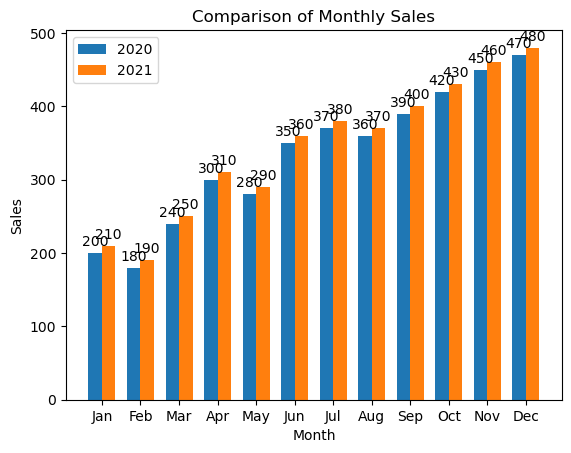

In [8]:
import matplotlib.pyplot as plt

# Sample data

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

sales_2020 = [200, 180, 240, 300, 280, 350, 370, 360, 390, 420, 450, 470]

sales_2021 = [210, 190, 250, 310, 290, 360, 380, 370, 400, 430, 460, 480]

# Creating the bar chart

x = range(len(months))  # the label locations

width = 0.35  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x, sales_2020, width, label='2020')

rects2 = ax.bar([p + width for p in x], sales_2021, width, label='2021')

# Add some text for labels, title, and custom x-axis tick labels, etc.

ax.set_xlabel('Month')

ax.set_ylabel('Sales')

ax.set_title('Comparison of Monthly Sales')

ax.set_xticks([p + width / 2 for p in x])

ax.set_xticklabels(months)

ax.legend()

# Function to add labels on bars

def autolabel(rects, ax):

    for rect in rects:

        height = rect.get_height()

        ax.annotate('{}'.format(height),

                    xy=(rect.get_x() + rect.get_width() / 2, height),

                    xytext=(0, 3),  # 3 points vertical offset

                    textcoords="offset points",

                    ha='center', va='bottom')

autolabel(rects1, ax)

autolabel(rects2, ax)

plt.show()

In [54]:
import seaborn as sns
import pandas as pd

titanic = sns.load_dataset('titanic')

# TODO: Group by 'class' and calculate mean fare and median age

class_aggregated = titanic.groupby('class').agg({
    'fare' : 'mean',
    'age'  : 'median'
    
})

print(class_aggregated)

             fare   age
class                  
First   84.154687  37.0
Second  20.662183  29.0
Third   13.675550  24.0


/var/folders/k4/x11w534x6fx5843q4r1vdmtc0000gp/T/ipykernel_59786/914613944.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  class_aggregated = titanic.groupby('class').agg({


In [ ]:
from collections import defaultdict

def solution(numbers):
   counts = defaultdict(int)
   answer = 0
   for element in numbers:
       counts[element] += 1
       for two_power in range(21):
           second_element = (1 << two_power) - element #  a << n = a * 2**n
           print(second_element)
           answer += counts[second_element]
   return answer 

numbers = [1, 3, 5, 7, 9]
print(solution(numbers))

0
1
3
7
15
31
63
127
255
511
1023
2047
4095
8191
16383
32767
65535
131071
262143
524287
1048575
-2
-1
1
5
13
29
61
125
253
509
1021
2045
4093
8189
16381
32765
65533
131069
262141
524285
1048573
-4
-3
-1
3
11
27
59
123
251
507
1019
2043
4091
8187
16379
32763
65531
131067
262139
524283
1048571
-6
-5
-3
1
9
25
57
121
249
505
1017
2041
4089
8185
16377
32761
65529
131065
262137
524281
1048569
-8
-7
-5
-1
7
23
55
119
247
503
1015
2039
4087
8183
16375
32759
65527
131063
262135
524279
1048567
5


You have a pandas DataFrame df containing three years of hourly sales data with columns ‘Date_Time’ (datetime) and ‘Sales’ (float). Write a Python code snippet to resample this data to a weekly format and compute the total sales and average sales per week.”

In [ ]:
import pandas as pd

# Assuming df is already defined and loaded with data

# Ensure 'Date_Time' column is in datetime format

df['Date_Time'] = pd.to_datetime(df['Date_Time'])

# Set 'Date_Time' as the DataFrame index

df.set_index('Date_Time', inplace=True)

# Resample data to weekly, calculate sum and mean of 'Sales'

weekly_sales = df.resample('W').agg({'Sales': ['sum', 'mean']})

# Renaming columns for clarity

weekly_sales.columns = ['Total_Weekly_Sales', 'Average_Weekly_Sales']

In [ ]:
import pandas as pd

# Sample sales data with various date formats
data = {
    'order_date': ['2023-12-25', 'Jan 15, 2024', '2024-01-20', 'February 1, 2024']
}
sales = pd.DataFrame(data)

# Convert 'order_date' to datetime
sales['order_date'] = pd.to_datetime(sales['order_date'], format='mixed')

# Extract month from datetime and create a new column 'month'
sales['month'] = sales['order_date'].dt.month

print(sales)

# Sales data with date information
data = {'order_date': ['2023/01/05', '2023/02/15', '2023/03/10']}
sales = pd.DataFrame(data)

# TODO: Convert 'order_date' to datetime format

sales['order_date'] = pd.to_datetime(sales['order_date'], format='mixed')

# Extract month from 'order_date' 
sales['month'] = sales['order_date'].dt.month
# TODO: Calculate days since each order date and put it into a separate days_since_order column
current_date = datetime.now()  #CURRENT DATETIME
sales['days_since_order'] = current_date - sales['order_date']

print(sales)


# transfomrer une string date en datetime 

reference_date = pd.to_datetime('2023-10-05')

  order_date  month
0 2023-12-25     12
1 2024-01-15      1
2 2024-01-20      1
3 2024-02-01      2


Question 1: Using basic TensorFlow operations
Prompt: Demonstrate how to create a TensorFlow constant tensor and a variable tensor. Perform a basic arithmetic operation (like addition) between them and print the result.

In [ ]:
import tensorflow as tf
# Creating a constant and a variable tensor
const_tensor = tf.constant([1, 2, 3])
var_tensor = tf.Variable([4, 5, 6])
# Performing addition
result = const_tensor + var_tensor
print(result.numpy())

Using TensorFlow, create a simple neural network model to classify handwritten digits (you can use the MNIST dataset). Describe the model architecture, compile the model, and outline the training process.

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0
# Building the model
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
# Compiling the model
model.compile(optimizer=SGD(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Training the model
model.fit(train_images, train_labels, epochs=5)
# Evaluate the model
model.evaluate(test_images, test_labels)

Prompt: Write a custom loss function in TensorFlow and demonstrate how to use it in training a model. Explain in what scenarios custom loss functions are necessary and how they are integrated into the training process.

In [ ]:
import tensorflow as tf
# Custom loss function
def custom_loss_function(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))
# Example model (could be any model)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(input_shape,)),
    tf.keras.layers.Dense(1)
])
# Compile the model with the custom loss function
model.compile(optimizer='adam', loss=custom_loss_function)
# Train the model
# model.fit(X_train, y_train, epochs=10)

In [ ]:
import pandas as pd
def process_data(df_sales, df_customers):
    merged = pd.merge(df_sales, df_customers, on='customer_id')
    return merged.groupby('region')['total'].sum().reset_index()

# Exemple ML basique (linear regression)
import numpy as np
def linear_regression(x, y):
    m = np.cov(x, y)[0,1] / np.var(x)
    b = np.mean(y) - m * np.mean(x)
    return lambda input: m * input + b

# Tetris pattern 

In [ ]:
def solution(field, figure):
   height = len(field)
   width = len(field[0])
   figure_size = len(figure)
 
   for column in range(width - figure_size + 1):
       row = 1
       while row < height - figure_size + 1:
           can_fit = True
           for dx in range(figure_size):
               for dy in range(figure_size):
                   if field[row + dx][column + dy] == 1 and figure[dx][dy] == 1:
                       can_fit = False
           if not can_fit:
               break
           row += 1
       row -= 1
 
       for dx in range(figure_size):
           row_filled = True
           for column_index in range(width):
            if not (field[row + dx][column_index] == 1 or
                    (column <= column_index < column + figure_size and
                  figure[dx][column_index - column] == 1)):
                row_filled = False
           if row_filled:
               return column
   return -1

# Exo prépa BCG COde signal

In [80]:
count = 0
nums = [1, 2, 3, 4, 5]
target = 4
for element in nums :
    if element < target :
        count += element

print(count)

6


In [12]:
s = 'hello world'


l = ' '.join((s.split())[::-1])
print(l)


world hello


Énoncé:
Étant donné un array nums contenant n nombres distincts pris dans la range [0, n], trouver le seul nombre manquant dans cette range.

In [ ]:
def sol(nums):
    hash = {}

    lis = [x for x in range(len(nums)+1)]
    print(lis)
    for i,element in enumerate(nums):
        hash[element] = i
    
    for element in lis:
        if element not in hash :
            return(element)

    
nums = [9,6,4,2,3,5,7,0,1]
print(sol(nums))

def solution(nums):
    """
    Trouver le nombre manquant dans [0, n].
    """
    n = len(nums)
    
    # Somme attendue: 0 + 1 + 2 + ... + n
    expected_sum = n * (n + 1) // 2
    
    # Somme actuelle
    actual_sum = sum(nums)
    
    # Le manquant
    return expected_sum - actual_sum

# Étant donné un array d'entiers `nums`, déplacer tous les `0` à la fin en gardant l'ordre relatif des éléments non-zéro. Modification **IN PLACE** (sans créer nouveau array).
# Two pointers 

nums = [0, 1, 0, 3, 12]

def sol2(nums):
    
    # Pointeur pour la position du prochain élément non-zéro
    left = 0
    
    # Parcourir l'array
    for right in range(len(nums)):
        print(left, right)
        if nums[right] != 0:
            # Swap avec position left
            nums[left], nums[right] = nums[right], nums[left]
            left += 1
    
    return nums  # Pour les tests (pas nécessaire car in-place)

sol2(nums)

# Étant donné un array d'entiers `nums`, retourner `True` si une valeur apparaît au moins deux fois, `False` si tous les éléments sont distincts.

nums = [1, 2, 3, 4]

def sol3(nums):
    from collections import Counter 

    dico = Counter(nums)

    for element in dico.values():
        if element > 1:
            return True
    return False
    # Méthode 2: Plus concise avec un set 
    return len(nums) != len(set(nums))
    seen = set()
    for num in nums:
        if num in seen:
            return True
        seen.add(num)
    return False
sol3(nums)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
8
0 0
0 1
1 2
1 3
2 4


False

In [ ]:
# Trouver la longueur du plus long substring sans caractères répétés dans une string `s`.*
# Utiliser sliding window avec un set pour tracker les caractères uniques.



# Questions 

Question: How do you decide which machine learning model to use for a specific problem? For instance, how would you approach a dataset predicting customer churn?

Sample answer: When deciding on a model, I start by considering the nature of the data, the problem type (classification or regression), and the interpretability required by stakeholders. Predicting customer churn is a binary classification problem, so I might start with logistic regression for its simplicity and interpretability. I would also consider tree-based models like Random Forest or Gradient Boosting Machines for their robustness and ability to handle non-linear relationships. I typically compare a few models based on their performance metrics like accuracy, ROC-AUC, and F1-score, and validate them using techniques like cross-validation before making a final decision.

Question: What strategies do you employ to prevent overfitting in a machine learning model?

Sample answer: To prevent overfitting, I use several techniques depending on the model and data. First, I might split the data into training, validation, and test sets to monitor and prevent overfitting during model training. Regularization methods such as L1 or L2 regularization are also effective, especially in regression models. For decision trees, I control overfitting by setting limits on tree depth, minimum samples per leaf, and other parameters. And ensemble methods like bagging and boosting can reduce overfitting by building more robust models from multiple learning algorithms.

Question: Describe how you evaluate the performance of a machine learning model. Can you give an example of how you’ve applied these evaluation techniques in a past project?

Sample answer: I evaluate machine learning models using several key performance metrics. For classification tasks, I look at accuracy, precision, recall, F1-score, and the ROC-AUC curve. For regression, I consider metrics like RMSE and MAE. In a past project aimed at predicting real estate prices, I used RMSE to measure the average error between the predicted prices and the actual prices. I also used cross-validation to ensure that the model’s performance was consistent across different subsets of the data. These metrics helped us fine-tune the model iteratively, which led to more reliable predictions.

Question: Can you describe how you would use AI to improve the predictive analytics process within a company? Specifically, how would AI enhance the accuracy and efficiency of forecasting models?

Sample answer: AI can significantly enhance predictive analytics by incorporating more complex algorithms, such as deep learning, that are capable of identifying non-linear relationships and interactions that traditional models might miss. For instance, I would use recurrent neural networks (RNNs) or LSTM (Long Short-Term Memory) networks for forecasting sales data, as they are particularly good with sequences and can predict based on the historical data trends. Additionally, AI can automate the feature engineering process, using techniques like feature selection and dimensionality reduction to improve model accuracy and efficiency.

Question: You are tasked with designing a data collection strategy for a new app that tracks user interactions with various features. What factors would you consider when deciding what data to collect, and how would you ensure the data remains manageable and useful for analysis?

Sample answer: When designing a data collection strategy for the app, I would first identify the key metrics that align with our business objectives, such as user engagement times, frequency of feature use, and user feedback scores. I would ensure that the data collected is both relevant and sufficient to inform decision-making without collecting unnecessary information that could complicate processing and storage. To keep the data manageable, I would implement a schema that organizes data into structured formats and use automation tools to clean and preprocess the data as it comes in. This could involve setting up pipelines that automatically remove duplicates, handle missing values, and ensure data integrity. 

Question: You receive a dataset containing customer transaction data over the past year. The dataset is incomplete with numerous missing values and some duplicate entries. How would you go about cleaning this data to prepare it for analysis?

Sample answer: To clean the dataset, I would first assess the extent and nature of the missing values. For categorical data, I might impute missing values using the mode or a predictive model, whereas for numerical data, I might use mean, median, or regression imputation, depending on the distribution and the amount of missing data. To address duplicates, I would identify unique transaction identifiers or a combination of variables (like date, time, and customer ID) that can confirm a transaction’s uniqueness. I would then remove duplicates based on these identifiers. After handling missing values and duplicates, I would validate the data for consistency and accuracy, ensuring that all data types are correct and that there are no illogical data entries, such as negative transaction amounts. To do this, I’d use both automated scripts for bulk cleaning and manual checks for nuanced errors. Finally, I’d document the cleaning process to allow for reproducibility and maintain a clean dataset for future analysis.

Question: Could you describe a scenario where a Poisson distribution would be more appropriate to model an event than a normal distribution? How would you apply this in a data-driven decision-making process?

Sample answer: A Poisson distribution is ideal for modeling the number of times an event happens in a fixed interval of time or space when these events occur with a known constant mean rate and independently of the time since the last event. For example, it could model the number of users visiting a website per minute. This differs from a normal distribution, which is used for continuous data and where we’re looking at the distribution of means rather than actual event counts. In a business context, I’d use Poisson to predict customer arrivals or fault rates in a time frame.

Question: Imagine you’re tasked with evaluating the effectiveness of two different marketing campaigns. What statistical test would you use to determine which campaign was more successful, and why?

Sample answer: To evaluate the effectiveness of two marketing campaigns, I would use a hypothesis test, specifically an independent samples t-test, if the data is normally distributed. This test compares the means of two independent groups in order to determine whether there is statistical evidence that the associated population means are significantly different. I would set up the null hypothesis to assume no difference between the campaigns’ effects, and the alternative hypothesis to indicate a significant difference. The result would inform whether any observed difference in campaign performance is statistically significant or not.

Question: Can you walk me through how you would design an A/B test for a new product feature on a website? What steps would you take to ensure the results are statistically significant?

Sample answer: When designing an A/B test for a new product feature, I would start by defining clear metrics of success, such as conversion rate or user engagement time. I would then randomly assign users to two groups, ensuring each has a similar demographic makeup. The test would run long enough to collect sufficient data, using statistical power calculations to determine this duration. Lastly, I’d analyze the results using a hypothesis test—such as a chi-square test or a t-test, depending on the distribution and nature of the data—to determine if there’s a statistically significant difference between the two groups’ performance.

Question: After running an A/B test on two different email marketing campaigns, Campaign A resulted in a 15% click-through rate (CTR) while Campaign B resulted in a 10% CTR. What conclusions can you draw from these results, and what would be your next steps?

Sample answer: From the results of the A/B test, it appears that Campaign A performed better than Campaign B. This suggests that the elements or messaging used in Campaign A were more effective in engaging users and encouraging them to click on the links provided. My next steps would be to analyze the specific components of Campaign A to understand what drove the higher engagement, such as the email subject line, graphics, or call-to-action. I would also recommend further testing to confirm these results over multiple iterations and different user segments to ensure that the observed difference wasn’t due to external factors or variances in the audience groups. If the results remain consistent, I would consider applying the successful elements of Campaign A to other marketing materials and strategies to potentially improve overall marketing effectiveness.

# Audrey extract


In [64]:
import os

# Pour Mac avec Homebrew (M1/M2/M3)
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"

# OU pour Mac Intel
# os.environ["PATH"] += os.pathsep + "/usr/local/bin"

# Vérifier que poppler est accessible
import subprocess
try:
    result = subprocess.run(['pdftoppm', '-h'], capture_output=True)
    print("✅ Poppler trouvé !")
except FileNotFoundError:
    print("❌ Poppler non trouvé")

✅ Poppler trouvé !


In [74]:
"""
Script intelligent pour extraire des pages PDF et les insérer automatiquement
dans le document Word sous la bonne société du portfolio
VERSION AMÉLIORÉE : avec recadrage d'images et une société par page v3
"""

import os
import base64
from pdf2image import convert_from_path
from docx import Document
from docx.shared import Inches, Pt
from docx.enum.text import WD_BREAK
from mistralai import Mistral
from PIL import Image, ImageChops


# ========================================================================
# CONFIGURATION
# ========================================================================
POPPLER_PATH = "/opt/homebrew/bin"  # Mac M1/M2/M3

# Configuration Mistral
MISTRAL_API_KEY = "X7DpYENEsRkosAnYZJbd6exXoUDhETWy"
MISTRAL_MODEL = "mistral-medium-latest"
MISTRAL_SERVER_URL = "https://api.05d3a00300de.dc.mistral.ai"

# Configuration du recadrage
CROP_MARGIN = 20  # Pixels à garder autour du contenu (pour éviter de trop couper)

# Liste des sociétés du portfolio
COMPANIES = [
    "CASAVO",
    "SKILLVUE",
    "TUNDR",
    "ENERGY DOME",
    "CIRCULAR MATERIALS",
    "RESILCO",
    "KAMPAAY",
    "MOVOPACK",
    "NEWTWEN",
    "SOOURCE",
    "NEURONOVA",
    "JAMPY",
    "ZEFI",
    "ISAAC",
    "GUIDOIO",
    "TALENTWARE",
    "VOIDLESS",
    "EQUIXLY",
    "PHONONIC VIBES",
    "INGAGE"
]
# ========================================================================


def crop_white_borders(image_path, output_path=None, margin=20):
    """
    Recadre les bords blancs d'une image
    
    Args:
        image_path: Chemin de l'image source
        output_path: Chemin de l'image recadrée (si None, écrase l'original)
        margin: Pixels à garder autour du contenu
    
    Returns:
        Chemin de l'image recadrée
    """
    print(f"  ✂️  Recadrage des bords blancs: {os.path.basename(image_path)}")
    
    # Ouvrir l'image
    img = Image.open(image_path)
    
    # Convertir en RGB si nécessaire
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Créer un fond blanc de la même taille
    bg = Image.new('RGB', img.size, (255, 255, 255))
    
    # Calculer la différence entre l'image et le fond blanc
    diff = ImageChops.difference(img, bg)
    
    # Trouver la bounding box du contenu (non-blanc)
    bbox = diff.getbbox()
    
    if bbox:
        # Ajouter une marge
        left = max(0, bbox[0] - margin)
        top = max(0, bbox[1] - margin)
        right = min(img.width, bbox[2] + margin)
        bottom = min(img.height, bbox[3] + margin)
        
        # Recadrer l'image
        cropped = img.crop((left, top, right, bottom))
        
        # Sauvegarder
        if output_path is None:
            output_path = image_path
        cropped.save(output_path, 'PNG', quality=95)
        
        print(f"     → Image recadrée: {img.size} → {cropped.size}")
    else:
        print(f"     → Pas de recadrage nécessaire")
        if output_path and output_path != image_path:
            img.save(output_path, 'PNG', quality=95)
    
    return output_path


def extract_pdf_pages_to_png(pdf_path, output_folder="extracted_pages", poppler_path=None, crop_images=True):
    """Extrait chaque page d'un PDF en images PNG et les recadre"""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    print(f"📄 Conversion du PDF '{pdf_path}' en images...")
    
    if poppler_path:
        images = convert_from_path(pdf_path, dpi=300, poppler_path=poppler_path)
    else:
        images = convert_from_path(pdf_path, dpi=300)
    
    png_paths = []
    for i, image in enumerate(images, start=1):
        png_path = os.path.join(output_folder, f"page_{i}.png")
        image.save(png_path, "PNG")
        print(f"  ✓ Page {i} sauvegardée: {png_path}")
        
        # Recadrer l'image si demandé
        if crop_images:
            crop_white_borders(png_path, margin=CROP_MARGIN)
        
        png_paths.append(png_path)
    
    print(f"\n✅ {len(png_paths)} pages extraites avec succès!\n")
    return png_paths


def image_to_base64(image_path):
    """Convertit une image en base64"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


def identify_company_with_mistral(image_path, companies_list):
    """
    Utilise Mistral pour identifier de quelle société il s'agit
    """
    print(f"🤖 Analyse de l'image avec Mistral: {os.path.basename(image_path)}")
    
    try:
        # Initialiser le client Mistral
        client = Mistral(
            server_url=MISTRAL_SERVER_URL,
            api_key=MISTRAL_API_KEY
        )
        
        # Convertir l'image en base64
        image_base64 = image_to_base64(image_path)
        
        # Préparer le prompt
        companies_str = ", ".join(companies_list)
        prompt = f"""Analyse cette image d'un document de reporting financier d'une startup.

Cette image concerne l'une de ces sociétés du portfolio : {companies_str}

Ta mission : identifier précisément de quelle société il s'agit en cherchant le nom de la société dans l'image (généralement en haut du document, dans le logo, ou dans un titre).

INSTRUCTIONS CRITIQUES :
1. Cherche le nom de la société dans le document (titre, logo, en-tête)
2. Compare-le avec la liste ci-dessus
3. Réponds UNIQUEMENT avec le nom EXACT tel qu'il apparaît dans ma liste ci-dessus
4. Si le nom a des espaces (exemple: "ENERGY DOME"), garde les espaces
5. N'ajoute AUCUNE explication, ponctuation ou texte supplémentaire
6. Réponds en MAJUSCULES

Exemples de bonnes réponses :
- ENERGY DOME
- CIRCULAR MATERIALS
- PHONONIC VIBES

Si tu ne trouves aucun nom de société de la liste dans l'image, réponds uniquement "UNKNOWN"."""

        # Appel à Mistral avec vision
        response = client.chat.complete(
            model=MISTRAL_MODEL,
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": prompt
                        },
                        {
                            "type": "image_url",
                            "image_url": f"data:image/png;base64,{image_base64}"
                        }
                    ]
                }
            ]
        )
        
        # Récupérer la réponse
        company = response.choices[0].message.content.strip().upper()
        
        # Nettoyer la réponse (enlever ponctuation, espaces multiples, etc.)
        company = company.replace(".", "").replace(",", "").replace("!", "").strip()
        company = " ".join(company.split())  # Normaliser les espaces
        
        # Normaliser aussi la liste des sociétés pour la comparaison
        companies_normalized = {c.upper().replace(" ", ""): c for c in companies_list}
        company_normalized = company.replace(" ", "")
        
        # Vérifier correspondance exacte (sans espaces)
        if company_normalized in companies_normalized:
            matched_company = companies_normalized[company_normalized]
            print(f"  ✅ Société identifiée: {matched_company}\n")
            return matched_company
        
        # Vérifier correspondance exacte (avec espaces)
        if company in companies_list:
            print(f"  ✅ Société identifiée: {company}\n")
            return company
        
        # Correspondance partielle
        print(f"  ⚠️  Réponse de Mistral: '{company}' - Non reconnue dans la liste")
        print(f"  ℹ️  Tentative de correspondance partielle...")
        
        # Essayer de trouver une correspondance partielle (version flexible)
        for comp in companies_list:
            comp_normalized = comp.upper().replace(" ", "")
            # Si le nom normalisé de la société est contenu dans la réponse
            if comp_normalized in company_normalized or company_normalized in comp_normalized:
                print(f"  ✅ Correspondance trouvée: {comp}\n")
                return comp
            # Essayer aussi avec les espaces
            if comp.upper() in company or company in comp.upper():
                print(f"  ✅ Correspondance trouvée: {comp}\n")
                return comp
        
        print(f"  ❌ Aucune correspondance trouvée\n")
        return "UNKNOWN"
            
    except Exception as e:
        print(f"  ❌ Erreur Mistral: {str(e)}\n")
        return "UNKNOWN"


def identify_company_manual(image_path, companies_list):
    """
    Méthode manuelle: demande à l'utilisateur d'identifier la société
    """
    print(f"\n📷 Image: {image_path}")
    print(f"Sociétés disponibles: {', '.join(companies_list)}")
    
    while True:
        company = input("Entrez le nom de la société (ou 'skip' pour ignorer): ").strip().upper()
        if company == 'SKIP':
            return "UNKNOWN"
        if company in companies_list:
            return company
        print(f"❌ '{company}' n'est pas dans la liste. Réessayez.")


def insert_images_by_company_one_per_page(template_path, output_path, images_mapping, width_inches=6.5):
    """
    Insère les images dans le document Word : UNE SOCIÉTÉ PAR PAGE
    Ignore le sommaire (liste à puces) et insère uniquement dans la zone détails
    
    Args:
        template_path: Chemin du document Word template
        output_path: Chemin du document de sortie
        images_mapping: Dict {company_name: image_path}
        width_inches: Largeur des images en pouces
    """
    print(f"📝 Ouverture du document Word: '{os.path.basename(template_path)}'")
    doc = Document(template_path)
    
    insertions_made = 0
    section_found = False
    sommaire_zone = False
    detail_zone = False
    companies_in_details = []
    
    # Étape 1: Identifier les zones et les sociétés dans la zone détails
    for para_idx, paragraph in enumerate(doc.paragraphs):
        text = paragraph.text.strip().upper()
        
        # Détecter la section 4.3
        if '4.3' in text and 'PORTFOLIO' in text:
            section_found = True
            print(f"\n✓ Section '4.3 Current Portfolio' trouvée au paragraphe {para_idx}")
            continue
        
        if section_found:
            # Détecter le début du sommaire (liste à puces)
            is_bullet = paragraph.style.name.startswith('List')
            is_bold = any(run.bold for run in paragraph.runs)
            
            if is_bullet and not sommaire_zone and not detail_zone:
                sommaire_zone = True
                print(f"  → Sommaire détecté (paragraphe {para_idx}), IGNORÉ")
                continue
            
            # Dans la zone sommaire, on ignore
            if sommaire_zone and not detail_zone:
                if not is_bullet:
                    # Premier paragraphe non-bullet après le sommaire = début de la zone détails
                    # Il peut être en gras ou non, l'important c'est qu'il ne soit plus une bullet
                    if text and len(text) < 50:
                        # Fin du sommaire, début de la zone détails
                        detail_zone = True
                        sommaire_zone = False
                        print(f"  → Zone détails détectée (paragraphe {para_idx})")
                        # Ne pas continuer, traiter ce paragraphe comme un titre
                else:
                    continue  # On ignore le sommaire
            
            # Dans la zone détails, on identifie les titres de sociétés
            if detail_zone:
                # Arrêter si on arrive à une autre section
                if text and any(text.startswith(str(i)) for i in range(1, 10)) and '.' in text[:5]:
                    print(f"  → Fin de la section détectée au paragraphe {para_idx}")
                    break
                
                # Identifier les titres de sociétés (MAJUSCULES, court, dans la liste)
                # Note: on ne vérifie PAS le gras car tous les titres ne le sont pas
                if text and len(text) < 50 and text in [comp.upper() for comp in COMPANIES]:
                    company_name = text
                    if company_name in images_mapping:
                        companies_in_details.append({
                            'name': company_name,
                            'para_idx': para_idx,
                            'paragraph': paragraph
                        })
                        print(f"  → Société trouvée dans détails: {company_name} au paragraphe {para_idx}")
    
    print(f"\n📊 {len(companies_in_details)} sociétés trouvées dans la zone détails")
    
    # Étape 2: Insérer les images (en ordre inverse pour ne pas décaler les indices)
    # Mais on garde la logique des sauts de page en ordre normal
    for position, company_info in enumerate(reversed(companies_in_details)):
        company_name = company_info['name']
        para = company_info['paragraph']
        
        # Calculer la position réelle (non inversée) pour les sauts de page
        real_position = len(companies_in_details) - 1 - position
        
        if company_name in images_mapping:
            image_path = images_mapping[company_name]
            
            # Créer un nouveau paragraphe pour l'image juste après le nom
            new_paragraph = doc.add_paragraph()
            ref_p_element = para._element
            new_p_element = new_paragraph._element
            new_p_element.getparent().remove(new_p_element)
            ref_p_element.addnext(new_p_element)
            
            # Ajouter l'image
            run = new_paragraph.add_run()
            run.add_picture(image_path, width=Inches(width_inches))
            
            print(f"  ✅ Image insérée pour {company_name}")
            insertions_made += 1
            
            # Ajouter un saut de page APRÈS l'image
            # SAUF pour la dernière société (real_position == len - 1)
            if real_position < len(companies_in_details) - 1:
                # Créer un paragraphe vide avec un saut de page
                page_break_para = doc.add_paragraph()
                pb_p_element = page_break_para._element
                pb_p_element.getparent().remove(pb_p_element)
                new_p_element.addnext(pb_p_element)
                
                # Ajouter le saut de page
                run_pb = page_break_para.add_run()
                run_pb.add_break(WD_BREAK.PAGE)
                
                print(f"     → Saut de page ajouté après {company_name}")
            else:
                print(f"     → Dernière société, pas de saut de page")
    
    # Sauvegarder le document
    doc.save(output_path)
    print(f"\n✅ Document sauvegardé: '{output_path}'")
    print(f"✅ {insertions_made} image(s) insérée(s) dans la zone détails")
    print(f"✅ Format: 1 société par page")
    
    # Afficher les sociétés sans image
    companies_with_images = set(images_mapping.keys())
    companies_in_doc_names = set(c['name'] for c in companies_in_details)
    companies_without_images = companies_in_doc_names - companies_with_images
    if companies_without_images:
        print(f"\n⚠️  Sociétés sans image: {', '.join(companies_without_images)}")


def main(use_mistral=True, crop_images=True):
    """
    Fonction principale
    
    Args:
        use_mistral: Si True, utilise Mistral pour l'identification automatique
        crop_images: Si True, recadre les images pour enlever les bords blancs
    """
    print("=" * 70)
    print("🚀 EXTRACTION ET INSERTION AUTOMATIQUE DES DOCUMENTS PORTFOLIO")
    print("=" * 70)
    
    # Configuration
    pdf_path = "audrey_extract/SICAF one-pager 06.11.25 v2.pdf"
    template_word = "audrey_extract/Reporting SICAF - Q3 2025 v3.docx"
    output_word = "Reporting_Final_Avec_Documents_finalfinal.docx"
    
    # Étape 1: Extraire les pages du PDF
    print("\n📋 ÉTAPE 1: EXTRACTION DES PAGES PDF")
    print("-" * 70)
    png_images = extract_pdf_pages_to_png(pdf_path, poppler_path=POPPLER_PATH, crop_images=crop_images)
    
    # Étape 2: Identifier les sociétés sur chaque image
    print("\n🔍 ÉTAPE 2: IDENTIFICATION DES SOCIÉTÉS")
    print("-" * 70)
    
    images_mapping = {}  # {company_name: image_path}
    
    for image_path in png_images:
        if use_mistral:
            company = identify_company_with_mistral(image_path, COMPANIES)
        else:
            company = identify_company_manual(image_path, COMPANIES)
        
        if company != "UNKNOWN":
            images_mapping[company] = image_path
        else:
            print(f"  ⏭️  Image ignorée: {os.path.basename(image_path)}\n")
    
    # Afficher le résumé
    print("\n📊 RÉSUMÉ DES IDENTIFICATIONS:")
    print("-" * 70)
    if images_mapping:
        for company, image in images_mapping.items():
            print(f"  • {company}: {os.path.basename(image)}")
    else:
        print("  ⚠️  Aucune image n'a été associée à une société")
        print("  💡 Conseil: Vérifiez que les noms des sociétés sont visibles dans les images")
        return
    
    # Étape 3: Insérer les images dans le document Word (1 par page)
    print("\n📝 ÉTAPE 3: INSERTION DANS LE DOCUMENT WORD (1 SOCIÉTÉ PAR PAGE)")
    print("-" * 70)
    insert_images_by_company_one_per_page(template_word, output_word, images_mapping, width_inches=6.5)
    
    print("\n" + "=" * 70)
    print("✅ PROCESSUS TERMINÉ AVEC SUCCÈS!")
    print("=" * 70)
    print(f"\n📄 Document final: {output_word}")


if __name__ == "__main__":
    # Lancer avec Mistral automatique et recadrage d'images
    main(use_mistral=True, crop_images=True)
    
    # OU sans recadrage:
    # main(use_mistral=True, crop_images=False)
    
    # OU en mode manuel:
    # main(use_mistral=False, crop_images=True)

🚀 EXTRACTION ET INSERTION AUTOMATIQUE DES DOCUMENTS PORTFOLIO

📋 ÉTAPE 1: EXTRACTION DES PAGES PDF
----------------------------------------------------------------------
📄 Conversion du PDF 'audrey_extract/SICAF one-pager 06.11.25 v2.pdf' en images...
  ✓ Page 1 sauvegardée: extracted_pages/page_1.png
  ✂️  Recadrage des bords blancs: page_1.png
     → Image recadrée: (2481, 3508) → (2071, 2541)
  ✓ Page 2 sauvegardée: extracted_pages/page_2.png
  ✂️  Recadrage des bords blancs: page_2.png
     → Image recadrée: (2481, 3508) → (2079, 2557)
  ✓ Page 3 sauvegardée: extracted_pages/page_3.png
  ✂️  Recadrage des bords blancs: page_3.png
     → Image recadrée: (2481, 3508) → (2071, 2617)
  ✓ Page 4 sauvegardée: extracted_pages/page_4.png
  ✂️  Recadrage des bords blancs: page_4.png
     → Image recadrée: (2481, 3508) → (2071, 2590)
  ✓ Page 5 sauvegardée: extracted_pages/page_5.png
  ✂️  Recadrage des bords blancs: page_5.png
     → Image recadrée: (2481, 3508) → (2071, 2539)
  ✓ Page 6 sa

In [25]:
def solution(s):
    voyel = ['a', 'e', 'i', 'o', 'u','y']
    l = []
    for i in range (len(s)):
        if s[i].lower() in voyel:
            l.append(i)
    
    return l    

s = "Hello WORLD"
print(len(s))
print(solution(s))

11
[1, 4, 7]


In [ ]:
import numpy as np 

def solution(s):
    l = "abcdefghijklmnopqrstuvwxyz"
    l_upper = l.upper()
    result = []

    for i in range(len(s)):
        if s[i] == 'z' : 
            result.append("a")
        elif s[i] == 'Z' : 
            result.append("A")
        elif s[i] in l:
            result.append((l[l.index(s[i])+1]))
            
        elif s[i] in l_upper: 
            result.append((l_upper[l_upper.index(s[i])+1]))

        else : 
            result.append(s[i]) 

    return ''.join(result)
           
s = "Hello WORLZ"
print(len(s))
print(solution(s))

ord(char) retourne le code Unicode (un nombre entier) correspondant au caractère char.
chr(nombre) fait l’inverse : il retourne le caractère correspondant au code Unicode donné.



11
Ifmmp XPSMA


In [62]:
ord('Z')-ord('z')

-32

In [63]:
def solution(input_string):
    l = "abcdefghijklmnopqrstuvwxyz"
    l_upper = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    
    result = []
    for element in input_string:
        if element in l:
            result.append(chr(ord(element)-32))
        elif element in l_upper :
            result.append(chr(ord(element)+32))
        else : 
            result.append(element)
            
    return ''.join(result)

In [ ]:
def is_toeplitz(matrix: List[List[int]]) -> bool:
   work = np.array(matrix) 
   for i in range(len(matrix)-1):
      for j in range(len(matrix)-1):
         if work[i,j]!=work[i+1,j+1]:
            return False
   return True     

In [67]:
for i in range(12,1,-1):
    print(i)

12
11
10
9
8
7
6
5
4
3
2


# Boddak 

In [ ]:
import pandas as pd
import re

def extraire_nom_prenom(dirigeant):
    """
    Extrait le nom et le prénom d'une chaîne de dirigeant.
    Formats possibles: "Prénom Nom", "NOM Prénom", "Prénom NOM"
    """
    if pd.isna(dirigeant) or dirigeant == '':
        return '', ''
    
    # Nettoyer la chaîne
    dirigeant = str(dirigeant).strip()
    
    # Séparer par espaces
    parties = dirigeant.split()
    
    if len(parties) == 0:
        return '', ''
    elif len(parties) == 1:
        # Si un seul mot, on le met dans Surname
        return '', parties[0]
    else:
        # Si plusieurs mots, on considère:
        # - le premier mot comme prénom (Name)
        # - le reste comme nom de famille (Surname)
        prenom = parties[0]
        nom = ' '.join(parties[1:])
        return prenom, nom

# Charger le CSV
input_file = 'votre_fichier.csv'  # Remplacez par le nom de votre fichier
output_file = 'fichier_transforme.csv'

# Lire le CSV
df = pd.read_csv(input_file, encoding='utf-8', sep=',', low_memory=False)

# Extraire nom et prénom
df['Name'] = ''
df['Surname'] = ''

for idx, row in df.iterrows():
    prenom, nom = extraire_nom_prenom(row['dirigeant'])
    df.at[idx, 'Name'] = prenom
    df.at[idx, 'Surname'] = nom

# Créer les colonnes vides
df['Linkedin_scaped_url'] = ''
df['Notes'] = ''

# Définir l'ordre des colonnes selon votre demande
colonnes_finales = [
    'siren', 'siret', 'type_etablissement', 'denomination', 'nom_commercial',
    'nom_adressage', 'nom_enseigne', 'forme_juridique', 'statut_etablissement',
    'statut_siege', 'risk_siege', 'risk_description', 'procedure_collective_en_cours',
    'date_creation', 'date_cloture', 'dirigeant', 'Name', 'Surname',
    'Linkedin_scaped_url', 'Notes', 'lien_fiche', 'dirigeant_role',
    'dirigeant_role_date_debut', 'dirigeant_date_naissance', 'dirigeant_siren',
    'code_ape', 'libelle_ape', 'code_convention_collective',
    'libelle_convention_collective', 'nb_etablissements_actifs', 'rue',
    'code_postal', 'ville', 'code_departement', 'longitude', 'lattitude',
    'capital', 'categorie_insee', 'tva_intra'
]

# Sélectionner uniquement les colonnes qui existent dans le dataframe
colonnes_existantes = [col for col in colonnes_finales if col in df.columns]

# Créer le nouveau dataframe avec les colonnes sélectionnées
df_final = df[colonnes_existantes]

# Sauvegarder le résultat
df_final.to_csv(output_file, index=False, encoding='utf-8')

print(f"✓ Transformation terminée!")
print(f"✓ Fichier sauvegardé : {output_file}")
print(f"✓ Nombre de lignes : {len(df_final)}")
print(f"✓ Nombre de colonnes : {len(df_final.columns)}")
print(f"\nAperçu des premières lignes :")
print(df_final[['dirigeant', 'Name', 'Surname']].head(10))

In [49]:
df.query('name == "Laëtitia Amiault"')['url']

263    https://ua.linkedin.com/in/Laetitiaamiault
Name: url, dtype: object

In [55]:
import pandas as pd

df = pd.read_csv('datas/sd_mhm2y4ahta6bvw8jn.csv')
df = df.query("country_code == 'FR' ").reset_index()
df.iloc[:6]

,index,id,name,city,country_code,position,about,posts,current_company,experience,...,bio_links,first_name,last_name,timestamp,input_first_name,input_last_name,error,error_code,warning,warning_code
0,244,simon-wachter-814078225,Simon Wachter,"Bordeaux, Nouvelle-Aquitaine, France",FR,Commercial en charge des boutiques en ligne - ...,Actuellement en apprentissage chez Full Ace Sp...,NaN,"{""name"":""Full Ace Sport"",""company_id"":""fullace...","[{""title"":""Apprenti commercial"",""location"":""Mé...",...,[],Simon,Wachter,2025-11-05T14:15:45.901Z,NaN,NaN,NaN,NaN,NaN,NaN
1,249,simon-wachter-6791b62bb,Simon WACHTER,"Auvergne-Rhône-Alpes, France",FR,Étudiant à Lycee edgar quinet,NaN,NaN,"{""location"":null}",NaN,...,[],Simon,WACHTER,2025-11-05T14:15:54.653Z,NaN,NaN,NaN,NaN,NaN,NaN
2,252,simon-and-susan-wachter-3087b2142,Simon and Susan Wachter,Greater Angers Area,FR,"Joint Owner at 5 Grande Rue, Chambre D'Hote",NaN,NaN,"{""name"":""5 Grande Rue, Chambre D'Hote"",""title""...","[{""title"":""Joint Owner"",""description_html"":nul...",...,[],Simon,and Susan Wachter,2025-11-05T14:15:55.328Z,NaN,NaN,NaN,NaN,NaN,NaN
3,262,robinlobel,Robin Lobel,"Paris, Île-de-France, France",FR,Creator of audio software steinberg.net/spectr...,NaN,NaN,"{""name"":""TorchStudio.ai"",""company_id"":""torchst...","[{""title"":""Owner"",""location"":""Paris, Île-de-Fr...",...,[],Robin,Lobel,2025-11-05T14:16:03.777Z,NaN,NaN,NaN,NaN,NaN,NaN
4,269,david-poisson-90b5962,David Poisson,Greater Paris Metropolitan Region,FR,NaN,NaN,"[{""title"":""Winning teams - from concept to rea...","{""location"":null}",NaN,...,[],David,Poisson,2025-11-05T14:16:05.095Z,NaN,NaN,NaN,NaN,NaN,NaN
5,272,david-poisson-a3061b5,David Poisson,Greater Paris Metropolitan Region,FR,IT BI Team Lead at Business Objects,NaN,NaN,"{""link"":""https://www.linkedin.com/company/sapb...","[{""title"":""IT BI Team Lead"",""description_html""...",...,[],David,Poisson,2025-11-05T14:16:05.601Z,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
df['experience']

0      [{"title":"Apprenti commercial","location":"Mé...
1                                                    NaN
2      [{"title":"Joint Owner","description_html":nul...
3      [{"title":"Owner","location":"Paris, Île-de-Fr...
4                                                    NaN
                             ...                        
332    [{"title":"Ingénieur du son","description_html...
333    [{"title":"Chef d’équipe","description_html":n...
334                                                  NaN
335                                                  NaN
336    [{"title":"Conseillère Funéraire","location":"...
Name: experience, Length: 337, dtype: object

In [56]:
df.keys()

Index(['index', 'id', 'name', 'city', 'country_code', 'position', 'about',
       'posts', 'current_company', 'experience', 'url', 'people_also_viewed',
       'educations_details', 'education', 'recommendations_count', 'avatar',
       'courses', 'languages', 'certifications', 'recommendations',
       'volunteer_experience', 'followers', 'connections',
       'current_company_company_id', 'current_company_name', 'publications',
       'patents', 'projects', 'organizations', 'location', 'input_url',
       'linkedin_id', 'activity', 'linkedin_num_id', 'banner_image',
       'honors_and_awards', 'similar_profiles', 'default_avatar',
       'memorialized_account', 'bio_links', 'first_name', 'last_name',
       'timestamp', 'input_first_name', 'input_last_name', 'error',
       'error_code', 'warning', 'warning_code'],
      dtype='object')

In [43]:
df = df.drop_duplicates(subset=['name'])
df['url']

0      https://ch.linkedin.com/in/simon-wachter-81407...
1      https://id.linkedin.com/in/Simon-wachter-6791b...
2      https://ua.linkedin.com/in/Simon-and-susan-wac...
3                  https://fr.linkedin.com/in/Robinlobel
4       https://ph.linkedin.com/in/david-poisson-90b5962
                             ...                        
316    https://uk.linkedin.com/in/Antoine-d%E2%80%99h...
317           https://at.linkedin.com/in/kamal-bencharki
320         https://sg.linkedin.com/in/david-meyer-raedy
331    https://cn.linkedin.com/in/Nicolas-pouyoune-97...
335    https://ru.linkedin.com/in/Mohamed-addi-653276182
Name: url, Length: 96, dtype: object

# LSN pré filtre

In [4]:
import pandas as pd
from mistralai import Mistral

df = pd.read_csv("/Users/justinkim/Documents/GitHub/360capital/datas/extract_LSN - Feuille 1 (17).csv")


def classify_company_status(df, client, model):
    """
    Classifie les entreprises et met 'X' dans la colonne Status si elles ne correspondent 
    pas aux critères (France/Italie, ou Europe + climate tech, pas de consulting).
    
    Args:
        df: DataFrame contenant les données
        client: Client Mistral initialisé
        model: Nom du modèle Mistral à utiliser
    
    Returns:
        DataFrame avec la colonne Status mise à jour
    """
    
    def should_exclude(row):
        """
        Détermine si une entreprise doit être exclue (Status = X)
        """
        if pd.isna(row.get('Description')) or str(row.get('Description')).strip() == '':
            return None
        
        description = str(row['Description'])
        prompt = f"""

Analyze the company’s description below and determine whether to ‘EXCLURE’ or ‘GARDER’ based on the following criteria:

‘GARDER’ if:

The company is based in France or Italy.
The company operates in Europe and focuses on climate tech (renewable energy, decarbonization, etc.).
The company uses AI to address problems, or technology such as deeptech.
‘EXCLURE’ if:

The company is involved in consulting.
The company is non-profit or an association.
Respond only with ‘EXCLURE’ or ‘GARDER’.
If uncertain, choose ‘GARDER’.

Description: {description}


"""
        
        try:
            chat_response = client.chat.complete(
                model=model,
                messages=[
                    {
                        "role": "user",
                        "content": prompt,
                    }
                ]
            )
            
            response = chat_response.choices[0].message.content.strip().upper()
            

            if "EXCLURE" in response:
                return 'X'
            else:
                return None  
                
        except Exception as e:
            print(f"Erreur lors de la classification: {e}")
            return None
    

    print("Classification en cours...")

    df_copy = df.copy()
    for idx, row in df_copy.iterrows():
        result = should_exclude(row)
        if result == 'X':
            df_copy.at[idx, 'Status'] = 'X'
            if idx % 10 == 0: 
                print(f"Traité {idx + 1}/{len(df_copy)} lignes")
    
    print("Classification terminée!")
    return df_copy


# Config
api_key = "tLYewB74Gq1R7krnmU2fYaRVoHCx8wfl"
model = "mistral-small-latest"

client = Mistral(
    server_url="https://api.05d3a00300de.dc.mistral.ai",
    api_key=api_key
)

df_classified = classify_company_status(df, client, model)
df_classified.to_csv('companies_classified.csv', index=False)

Classification en cours...


/var/folders/k4/x11w534x6fx5843q4r1vdmtc0000gp/T/ipykernel_47623/1975220277.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'X' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_copy.at[idx, 'Status'] = 'X'


Traité 21/99 lignes
Traité 31/99 lignes
Traité 41/99 lignes
Traité 71/99 lignes
Traité 81/99 lignes
Classification terminée!


In [19]:
col = ['CompanyName', 'Status']
len(df_classified[col].dropna())

213

In [55]:
def Fizzbuzz(a):
    if a%3 ==0 :
        return "Fizz"
    elif a%5 ==0 :
        return "Buzz"
    elif a%5 ==0 and a%3 ==0 :
        return "FizzBuzz"
    else :
        return a
        
Fizzbuzz(3)

'Fizz'